## Identify TACO (Transfusion-associated circulatory overload) by ICD codes

In [18]:
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from google.cloud import bigquery
import matplotlib.pyplot as plt
import re
import seaborn as sns
pd.set_option('display.max_rows', 100)    # Show all rows



load_dotenv()
query_path = os.environ.get('BASE_QUERY_PATH')
client = bigquery.Client(os.environ.get('BIGQUERY_PROJECT_NAME'))

In [6]:
# ICD codes
with open(f"{query_path}/taco_icd_1d.sql", 'r') as file:
    query_icd = file.read()

results = client.query(query_icd).to_dataframe()
print(results)

/home/ch123ck/.pyenv/versions/3.12.7/envs/transfusion/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


      ROW_ID  SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE  ROW_ID_1 ICD9_CODE_1  \
0     430095       51200   102649       22      7851     12415        7851   
1     546228       76562   109750        4      7852     12986        7852   
2     609382       90911   175746       16      7852     12986        7852   
3     464155       58433   143337       12     78605     13000       78605   
4      18199        1616   177269        8     78605     13000       78605   
...      ...         ...      ...      ...       ...       ...         ...   
5636  404685       45803   127911       14     78609     13003       78609   
5637  617359       92652   127180       13     78609     13003       78609   
5638  533037       73713   107252        9     78609     13003       78609   
5639  414105       47862   199399       20     78609     13003       78609   
5640  417781       48637   148117        9     78609     13003       78609   

                 SHORT_TITLE                       LONG_TITLE  

In [47]:
icd_counts = results[['ICD9_CODE', 'LONG_TITLE']].drop_duplicates().reset_index()
icd_counts['Pt_Count'] = results.drop_duplicates(['SUBJECT_ID', 'ICD9_CODE']).groupby('ICD9_CODE').count().iloc[:,0].values
icd_counts

,index,ICD9_CODE,LONG_TITLE,Pt_Count
0,0,7851,Palpitations,215
1,1,7852,Undiagnosed cardiac murmurs,1926
2,3,78605,Shortness of breath,131
3,13,4280,"Congestive heart failure, unspecified",1586
4,3091,5184,"Acute edema of lung, unspecified",111
5,3223,7823,Edema,169
6,3336,7850,"Tachycardia, unspecified",4
7,3515,27669,Other fluid overload,4
8,3739,51881,Acute respiratory failure,5
9,5597,78609,Other respiratory abnormalities,43


In [48]:
icd_counts['Pt_Count'].sum()

np.int64(4194)

We're lacking temporal data still

## Identify TACO (Transfusion-associated circulatory overload) by lab values
lab values have time recorded 

In [3]:
# Lab values 
with open(f"{query_path}/taco_lab_1d.sql", 'r') as file:
    query_icd = file.read()

results = client.query(query_icd).to_dataframe()
print(results)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ch123ck/transfusion-reactions/queries/taco_lab_1d.sql'

In [15]:
lab_vars = results['LABEL'].values

HR_var = [item for item in lab_vars if re.findall("heart rate", item, re.IGNORECASE)]
HR_var

['Heart rate Alarm - High',
 'Heart Rate',
 'Heart Rate',
 'Heart Rate Alarm - Low']

In [12]:
RR_var = [item for item in lab_vars if re.findall("Resp rate", item, re.IGNORECASE)]
RR_var

['Resp Rate (Spont)', 'Resp Rate (Total)']

In [13]:
SpO2_var = [item for item in lab_vars if re.findall("spo2", item, re.IGNORECASE)]
SpO2_var

['SpO2 Desat Limit', 'SpO2 Alarm [Low]', 'SpO2', 'SpO2 Alarm [High]', 'SpO2-L']

In [14]:
BP_var = [item for item in lab_vars if re.findall("blood pressure", item, re.IGNORECASE)]
BP_var

['Manual Blood Pressure Diastolic Left',
 'Arterial Blood Pressure mean',
 'ART Blood Pressure Alarm - High',
 'ART Blood Pressure Alarm - Low',
 'Arterial Blood Pressure Alarm - Low',
 'Arterial Blood Pressure Alarm - High',
 'ART Blood Pressure Alarm Source',
 'Non Invasive Blood Pressure diastolic',
 'Manual Blood Pressure Systolic Left',
 'Non-Invasive Blood Pressure Alarm - Low',
 'Non Invasive Blood Pressure mean',
 'Arterial Blood Pressure systolic',
 'Non-Invasive Blood Pressure Alarm - High',
 'Manual Blood Pressure Systolic Right',
 'Non Invasive Blood Pressure systolic',
 'Arterial Blood Pressure diastolic',
 'Manual Blood Pressure Diastolic Right']

Vital Variables: 

'Heart Rate' 

'Resp Rate (Spont)', 'Resp Rate (Total)'

'SpO2'

'Manual Blood Pressure Diastolic Left', 'Non Invasive Blood Pressure diastolic', 'Manual Blood Pressure Systolic Left', 'Manual Blood Pressure Systolic Right', 'Non Invasive Blood Pressure systolic', 'Arterial Blood Pressure systolic', 'Arterial Blood Pressure diastolic', 'Manual Blood Pressure Diastolic Right'

In [4]:
# results.to_csv('/home/ch123ck/transfusion-reactions/exploratory_data_analysis/chart_labels_2.csv')

### Clean vitals data before transfusion reaction

In [54]:
## Use sql to query vitals and time
## Get vitals before transfusion
# ICD codes
with open(f"{query_path}/taco_lab_12hr_before_mergedtr.sql", 'r') as file:
    query_icd = file.read()

before_results = client.query(query_icd).to_dataframe()
print(before_results)


/home/ch123ck/.pyenv/versions/3.12.7/envs/transfusion/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


         SUBJECT_ID           CHARTTIME           starttime  linkorderid  \
0             25490 2184-12-28 06:00:00 2184-12-28 12:30:00      8187814   
1             96238 2153-05-08 08:00:00 2153-05-08 12:20:00      7776602   
2             30256 2166-07-30 16:00:00 2166-07-30 23:30:00      3999328   
3             62795 2130-06-05 06:00:00 2130-06-05 06:41:00      2153841   
4             10425 2199-08-17 07:15:00 2199-08-17 08:29:00      3645610   
...             ...                 ...                 ...          ...   
2882242       79894 2104-04-07 11:00:00 2104-04-07 13:00:00      2053768   
2882243       41493 2175-09-07 04:48:00 2175-09-07 09:51:00      4582744   
2882244       41493 2175-09-07 07:29:00 2175-09-07 09:51:00      4582744   
2882245         222 2142-06-26 04:30:00 2142-06-26 14:00:00      2887115   
2882246       32739 2186-08-13 02:00:00 2186-08-12 23:01:00       243836   

         ITEMID                                 LABEL VALUE  VALUENUM  \
0        22017

In [55]:
# Look at the counts of each vital
before_results['LABEL'].value_counts()

LABEL
Heart Rate                               578237
Respiratory Rate                         570914
O2 saturation pulseoxymetry              551414
Arterial Blood Pressure systolic         309285
Arterial Blood Pressure diastolic        309229
Non Invasive Blood Pressure systolic     231435
Non Invasive Blood Pressure diastolic    231275
Respiratory Rate (spontaneous)            99807
Manual Blood Pressure Systolic Left         155
Manual Blood Pressure Diastolic Left        151
SpO2                                        121
Manual Blood Pressure Systolic Right        107
Manual Blood Pressure Diastolic Right        92
Resp Rate (Total)                            13
Respiratory Rate Set                          7
Resp Rate (Spont)                             5
Name: count, dtype: int64

In [56]:
## Unique patient counts 
print(f"n_patinets with at least one required vitals and received transfusion: {len(before_results['SUBJECT_ID'].unique())}")
print(f"n_transfusion events in which the patient has at least one required vtials: {len(before_results[['SUBJECT_ID', 'linkorderid']].drop_duplicates())}")

n_patinets with at least one required vitals and received transfusion: 5847
n_transfusion events in which the patient has at least one required vtials: 32768


In [57]:
# Look at a patient's heart rate data 
sub_hr = before_results[before_results['LABEL'] == 'Heart Rate'].sort_values(by=['SUBJECT_ID', 'CHARTTIME'])
sub_hr[sub_hr['SUBJECT_ID'] == 34]

,SUBJECT_ID,CHARTTIME,starttime,linkorderid,ITEMID,LABEL,VALUE,VALUENUM,VALUEUOM
1766582,34,2191-02-23 05:25:00,2191-02-23 16:19:00,852439,220045,Heart Rate,72,72.0,bpm
739669,34,2191-02-23 07:34:00,2191-02-23 16:19:00,852439,220045,Heart Rate,44,44.0,bpm
2020990,34,2191-02-23 08:00:00,2191-02-23 16:19:00,852439,220045,Heart Rate,43,43.0,bpm
1892973,34,2191-02-23 08:10:00,2191-02-23 16:19:00,852439,220045,Heart Rate,44,44.0,bpm
1379927,34,2191-02-23 08:20:00,2191-02-23 16:19:00,852439,220045,Heart Rate,44,44.0,bpm
2021000,34,2191-02-23 09:00:00,2191-02-23 16:19:00,852439,220045,Heart Rate,47,47.0,bpm
1444203,34,2191-02-23 10:00:00,2191-02-23 16:19:00,852439,220045,Heart Rate,56,56.0,bpm
1828802,34,2191-02-23 11:00:00,2191-02-23 16:19:00,852439,220045,Heart Rate,51,51.0,bpm
2724767,34,2191-02-23 12:00:00,2191-02-23 16:19:00,852439,220045,Heart Rate,52,52.0,bpm
2533600,34,2191-02-23 13:00:00,2191-02-23 16:19:00,852439,220045,Heart Rate,53,53.0,bpm


In [58]:
## Add category to the label 
# Define the conditions and categories
conditions = [
    (before_results['LABEL'] == 'Heart Rate'),
    (before_results['LABEL'].isin(['Arterial Blood Pressure systolic', 
                                   'Non Invasive Blood Pressure systolic', 
                                   'Manual Blood Pressure Systolic Left', 
                                   'Manual Blood Pressure Systolic Right'])),
    (before_results['LABEL'].isin(['Arterial Blood Pressure diastolic', 
                                   'Non Invasive Blood Pressure diastolic', 
                                   'Manual Blood Pressure Diastolic Left', 
                                   'Manual Blood Pressure Diastolic Right'])),
    (before_results['LABEL'].isin(['SpO2', 'O2 saturation pulseoxymetry'])),
    (before_results['LABEL'].isin(['Resp Rate (Total)', 'Resp Rate (Spont)', 'Respiratory Rate', 'Respiratory Rate Set', 'Respiratory Rate (spontaneous)']))
]

categories = ['HR', 'BP_SYS', 'BP_DIA', 'SPO2', 'RR']

# Set default to a string value like 'Unknown'
before_results['Category'] = np.select(conditions, categories, default='Unknown')
before_results # This table is useful for Sehyo' review of vital signs

,SUBJECT_ID,CHARTTIME,starttime,linkorderid,ITEMID,LABEL,VALUE,VALUENUM,VALUEUOM,Category
0,25490,2184-12-28 06:00:00,2184-12-28 12:30:00,8187814,220179,Non Invasive Blood Pressure systolic,32,32.0,mmHg,BP_SYS
1,96238,2153-05-08 08:00:00,2153-05-08 12:20:00,7776602,220179,Non Invasive Blood Pressure systolic,37,37.0,mmHg,BP_SYS
2,30256,2166-07-30 16:00:00,2166-07-30 23:30:00,3999328,220179,Non Invasive Blood Pressure systolic,42,42.0,mmHg,BP_SYS
3,62795,2130-06-05 06:00:00,2130-06-05 06:41:00,2153841,220179,Non Invasive Blood Pressure systolic,45,45.0,mmHg,BP_SYS
4,10425,2199-08-17 07:15:00,2199-08-17 08:29:00,3645610,220179,Non Invasive Blood Pressure systolic,50,50.0,mmHg,BP_SYS
...,...,...,...,...,...,...,...,...,...,...
2882242,79894,2104-04-07 11:00:00,2104-04-07 13:00:00,2053768,224689,Respiratory Rate (spontaneous),45,45.0,insp/min,RR
2882243,41493,2175-09-07 04:48:00,2175-09-07 09:51:00,4582744,224689,Respiratory Rate (spontaneous),49,49.0,insp/min,RR
2882244,41493,2175-09-07 07:29:00,2175-09-07 09:51:00,4582744,224689,Respiratory Rate (spontaneous),56,56.0,insp/min,RR
2882245,222,2142-06-26 04:30:00,2142-06-26 14:00:00,2887115,211,Heart Rate,57,57.0,BPM,HR


In [59]:
# Ensure STARTTIME and CHARTTIME are in datetime format
before_results['starttime'] = pd.to_datetime(before_results['starttime'])
before_results['CHARTTIME'] = pd.to_datetime(before_results['CHARTTIME'])

# Drop rows with missing 'VALUE' to avoid erroneous calculations
before_results_nan = before_results.dropna(subset=['VALUE'])

# Calculate the time difference between CHARTTIME and STARTTIME
before_results_nan['time_diff'] = abs(before_results_nan['CHARTTIME'] - before_results_nan['starttime'])

# Sort by SUBJECT_ID, linkorderid, Category, and time_diff (smallest first)
before_results_sorted = before_results_nan.sort_values(
    by=['SUBJECT_ID', 'linkorderid', 'Category', 'time_diff'], 
    ascending=[True, True, True, True]
)

# Drop duplicates to keep only the closest CHARTTIME for each SUBJECT_ID, linkorderid, and Category
before_unique = before_results_sorted.drop_duplicates(subset=['SUBJECT_ID', 'linkorderid', 'Category'], keep='first')

# Reset index for a clean DataFrame
before_unique = before_unique.reset_index(drop=True)

# Display the result
before_unique


,SUBJECT_ID,CHARTTIME,starttime,linkorderid,ITEMID,LABEL,VALUE,VALUENUM,VALUEUOM,Category,time_diff
0,34,2191-02-23 16:00:00,2191-02-23 16:19:00,852439,220180,Non Invasive Blood Pressure diastolic,57,57.0,mmHg,BP_DIA,0 days 00:19:00
1,34,2191-02-23 16:00:00,2191-02-23 16:19:00,852439,220179,Non Invasive Blood Pressure systolic,131,131.0,mmHg,BP_SYS,0 days 00:19:00
2,34,2191-02-23 16:00:00,2191-02-23 16:19:00,852439,220045,Heart Rate,55,55.0,bpm,HR,0 days 00:19:00
3,34,2191-02-23 16:00:00,2191-02-23 16:19:00,852439,220210,Respiratory Rate,19,19.0,insp/min,RR,0 days 00:19:00
4,34,2191-02-23 16:00:00,2191-02-23 16:19:00,852439,220277,O2 saturation pulseoxymetry,100,100.0,%,SPO2,0 days 00:19:00
...,...,...,...,...,...,...,...,...,...,...,...
162890,99995,2147-02-09 00:00:00,2147-02-09 00:00:00,7008601,220051,Arterial Blood Pressure diastolic,49,49.0,mmHg,BP_DIA,0 days 00:00:00
162891,99995,2147-02-09 00:00:00,2147-02-09 00:00:00,7008601,220050,Arterial Blood Pressure systolic,129,129.0,mmHg,BP_SYS,0 days 00:00:00
162892,99995,2147-02-09 00:00:00,2147-02-09 00:00:00,7008601,220045,Heart Rate,79,79.0,bpm,HR,0 days 00:00:00
162893,99995,2147-02-09 00:00:00,2147-02-09 00:00:00,7008601,220210,Respiratory Rate,24,24.0,insp/min,RR,0 days 00:00:00


In [60]:
# Count the number of vital signs and patients
print(before_unique['Category'].value_counts())
print(f"total n_patient with at least one required vitals and received transfusion: {len(before_unique['SUBJECT_ID'].unique())}")
print(f"n_transfusion events in which the patient has at least one required vtials before tranfusion: {len(before_unique[['SUBJECT_ID', 'linkorderid']].drop_duplicates())}")

Category
HR        32765
RR        32722
SPO2      32680
BP_DIA    32364
BP_SYS    32364
Name: count, dtype: int64
total n_patient with at least one required vitals and received transfusion: 5847
n_transfusion events in which the patient has at least one required vtials before tranfusion: 32768


### Clean vitals data after transfusion reaction

In [11]:
## Get vitals after transfusion
# ICD codes
with open(f"{query_path}/taco_lab_12hr_after_mergedtr.sql", 'r') as file:
    query_icd = file.read()

after_results = client.query(query_icd).to_dataframe()
print(after_results)


/home/ch123ck/.pyenv/versions/3.12.7/envs/transfusion/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


         SUBJECT_ID           CHARTTIME             endtime  linkorderid  \
0             15645 2157-04-06 18:00:00 2157-04-06 16:10:00      6799575   
1             96791 2144-06-11 22:36:00 2144-06-11 12:06:00      5485874   
2             96791 2144-06-11 22:36:00 2144-06-11 10:36:00      1615627   
3             96791 2144-06-11 08:02:00 2144-06-10 23:07:00       775176   
4             56593 2114-07-23 11:26:00 2114-07-23 04:06:00      8249652   
...             ...                 ...                 ...          ...   
2741216       29753 2188-08-28 05:00:00 2188-08-27 23:28:00      7526220   
2741217       29753 2188-08-28 01:00:00 2188-08-27 23:28:00      7526220   
2741218       32725 2193-09-16 18:30:00 2193-09-16 09:00:00      1659028   
2741219       32725 2193-09-16 15:00:00 2193-09-16 09:00:00      1659028   
2741220        8498 2144-08-27 07:15:00 2144-08-27 02:06:00      5605607   

         ITEMID                                 LABEL VALUE  VALUENUM VALUEUOM  
0     

In [12]:
# Look at the counts of each vital
print(f"Vitals counts : {after_results['LABEL'].value_counts()}")

## Unique patient counts 
print(f"total n_patient with at least one required vitals and received transfusion: {len(after_results['SUBJECT_ID'].unique())}")
print(f"n_transfusion events in which the patient has at least one required vtials after tranfusion: {len(after_results[['SUBJECT_ID', 'linkorderid']].drop_duplicates())}")

# Look at a patient's heart rate data 
sub_af_hr = after_results[after_results['LABEL'] == 'Heart Rate'].sort_values(by=['SUBJECT_ID', 'CHARTTIME'])
sub_af_hr[after_results['SUBJECT_ID'] == 34]

Vitals counts : LABEL
Heart Rate                               546342
Respiratory Rate                         540290
O2 saturation pulseoxymetry              527867
Arterial Blood Pressure systolic         308313
Arterial Blood Pressure diastolic        308263
Non Invasive Blood Pressure systolic     204423
Non Invasive Blood Pressure diastolic    204346
Respiratory Rate (spontaneous)           100891
SpO2                                        134
Manual Blood Pressure Systolic Left         110
Manual Blood Pressure Diastolic Left        104
Manual Blood Pressure Systolic Right         53
Manual Blood Pressure Diastolic Right        43
Resp Rate (Total)                            18
Respiratory Rate Set                         14
Resp Rate (Spont)                            10
Name: count, dtype: int64
total n_patient with at least one required vitals and received transfusion: 5827


n_transfusion events in which the patient has at least one required vtials after tranfusion: 32577


/tmp/ipykernel_1789/3627233497.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_af_hr[after_results['SUBJECT_ID'] == 34]


,SUBJECT_ID,CHARTTIME,endtime,linkorderid,ITEMID,LABEL,VALUE,VALUENUM,VALUEUOM
243125,34,2191-02-23 18:00:00,2191-02-23 17:19:00,852439,220045,Heart Rate,55,55.0,bpm
106047,34,2191-02-23 19:00:00,2191-02-23 17:19:00,852439,220045,Heart Rate,59,59.0,bpm
860906,34,2191-02-23 20:00:00,2191-02-23 17:19:00,852439,220045,Heart Rate,62,62.0,bpm
38122,34,2191-02-23 21:00:00,2191-02-23 17:19:00,852439,220045,Heart Rate,66,66.0,bpm
1409920,34,2191-02-23 22:00:00,2191-02-23 17:19:00,852439,220045,Heart Rate,61,61.0,bpm
1888133,34,2191-02-23 23:00:00,2191-02-23 17:19:00,852439,220045,Heart Rate,54,54.0,bpm
1546555,34,2191-02-24 00:00:00,2191-02-23 17:19:00,852439,220045,Heart Rate,56,56.0,bpm
311965,34,2191-02-24 01:00:00,2191-02-23 17:19:00,852439,220045,Heart Rate,57,57.0,bpm
997577,34,2191-02-24 02:00:00,2191-02-23 17:19:00,852439,220045,Heart Rate,55,55.0,bpm
243188,34,2191-02-24 03:00:00,2191-02-23 17:19:00,852439,220045,Heart Rate,56,56.0,bpm


In [13]:
## Add category to the label 
# Define the conditions and categories
conditions = [
    (after_results['LABEL'] == 'Heart Rate'),
    (after_results['LABEL'].isin(['Arterial Blood Pressure systolic', 
                                   'Non Invasive Blood Pressure systolic', 
                                   'Manual Blood Pressure Systolic Left', 
                                   'Manual Blood Pressure Systolic Right'])),
    (after_results['LABEL'].isin(['Arterial Blood Pressure diastolic', 
                                   'Non Invasive Blood Pressure diastolic', 
                                   'Manual Blood Pressure Diastolic Left', 
                                   'Manual Blood Pressure Diastolic Right'])),
    (after_results['LABEL'].isin(['SpO2', 'O2 saturation pulseoxymetry'])),
    (after_results['LABEL'].isin(['Resp Rate (Total)', 'Resp Rate (Spont)', 'Respiratory Rate', 'Respiratory Rate Set', 'Respiratory Rate (spontaneous)']))
]

categories = ['HR', 'BP_SYS', 'BP_DIA', 'SPO2', 'RR']

# Set default to a string value like 'Unknown'
after_results['Category'] = np.select(conditions, categories, default='Unknown')
after_results # This table is useful for Sehyo' review of vital signs

,SUBJECT_ID,CHARTTIME,endtime,linkorderid,ITEMID,LABEL,VALUE,VALUENUM,VALUEUOM,Category
0,15645,2157-04-06 18:00:00,2157-04-06 16:10:00,6799575,220179,Non Invasive Blood Pressure systolic,34,34.0,mmHg,BP_SYS
1,96791,2144-06-11 22:36:00,2144-06-11 12:06:00,5485874,220179,Non Invasive Blood Pressure systolic,37,37.0,mmHg,BP_SYS
2,96791,2144-06-11 22:36:00,2144-06-11 10:36:00,1615627,220179,Non Invasive Blood Pressure systolic,37,37.0,mmHg,BP_SYS
3,96791,2144-06-11 08:02:00,2144-06-10 23:07:00,775176,220179,Non Invasive Blood Pressure systolic,39,39.0,mmHg,BP_SYS
4,56593,2114-07-23 11:26:00,2114-07-23 04:06:00,8249652,220179,Non Invasive Blood Pressure systolic,43,43.0,mmHg,BP_SYS
...,...,...,...,...,...,...,...,...,...,...
2741216,29753,2188-08-28 05:00:00,2188-08-27 23:28:00,7526220,211,Heart Rate,80,80.0,BPM,HR
2741217,29753,2188-08-28 01:00:00,2188-08-27 23:28:00,7526220,211,Heart Rate,80,80.0,BPM,HR
2741218,32725,2193-09-16 18:30:00,2193-09-16 09:00:00,1659028,211,Heart Rate,92,92.0,BPM,HR
2741219,32725,2193-09-16 15:00:00,2193-09-16 09:00:00,1659028,211,Heart Rate,93,93.0,BPM,HR


### Examine before vs after transfusion vital signs 

In [61]:
# Perform a left join on SUBJECT_ID and Category
merged_results = after_results.merge(
    before_unique, 
    on=['SUBJECT_ID', 'linkorderid', 'Category'], 
    how='left', 
    suffixes=('_after', '_before')  # Add suffixes to distinguish overlapping columns
)

# Display the merged DataFrame
merged_results

,SUBJECT_ID,CHARTTIME_after,endtime,linkorderid,ITEMID_after,LABEL_after,VALUE_after,VALUENUM_after,VALUEUOM_after,Category,CHARTTIME_before,starttime,ITEMID_before,LABEL_before,VALUE_before,VALUENUM_before,VALUEUOM_before,time_diff
0,15645,2157-04-06 18:00:00,2157-04-06 16:10:00,6799575,220179,Non Invasive Blood Pressure systolic,34,34.0,mmHg,BP_SYS,NaT,NaT,<NA>,NaN,NaN,NaN,NaN,NaT
1,96791,2144-06-11 22:36:00,2144-06-11 12:06:00,5485874,220179,Non Invasive Blood Pressure systolic,37,37.0,mmHg,BP_SYS,2144-06-11 11:28:00,2144-06-11 11:09:00,220050,Arterial Blood Pressure systolic,97,97.0,mmHg,0 days 00:19:00
2,96791,2144-06-11 22:36:00,2144-06-11 10:36:00,1615627,220179,Non Invasive Blood Pressure systolic,37,37.0,mmHg,BP_SYS,2144-06-11 09:45:00,2144-06-11 10:06:00,220050,Arterial Blood Pressure systolic,111,111.0,mmHg,0 days 00:21:00
3,96791,2144-06-11 08:02:00,2144-06-10 23:07:00,775176,220179,Non Invasive Blood Pressure systolic,39,39.0,mmHg,BP_SYS,2144-06-10 22:35:00,2144-06-10 22:35:00,220050,Arterial Blood Pressure systolic,108,108.0,mmHg,0 days 00:00:00
4,56593,2114-07-23 11:26:00,2114-07-23 04:06:00,8249652,220179,Non Invasive Blood Pressure systolic,43,43.0,mmHg,BP_SYS,2114-07-23 03:00:00,2114-07-23 03:06:00,220050,Arterial Blood Pressure systolic,138,138.0,mmHg,0 days 00:06:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2741216,29753,2188-08-28 05:00:00,2188-08-27 23:28:00,7526220,211,Heart Rate,80,80.0,BPM,HR,2188-08-27 22:00:00,2188-08-27 22:05:00,211,Heart Rate,80,80.0,BPM,0 days 00:05:00
2741217,29753,2188-08-28 01:00:00,2188-08-27 23:28:00,7526220,211,Heart Rate,80,80.0,BPM,HR,2188-08-27 22:00:00,2188-08-27 22:05:00,211,Heart Rate,80,80.0,BPM,0 days 00:05:00
2741218,32725,2193-09-16 18:30:00,2193-09-16 09:00:00,1659028,211,Heart Rate,92,92.0,BPM,HR,2193-09-16 08:00:00,2193-09-16 08:00:00,220045,Heart Rate,98,98.0,bpm,0 days 00:00:00
2741219,32725,2193-09-16 15:00:00,2193-09-16 09:00:00,1659028,211,Heart Rate,93,93.0,BPM,HR,2193-09-16 08:00:00,2193-09-16 08:00:00,220045,Heart Rate,98,98.0,bpm,0 days 00:00:00


In [62]:
# Examine before missing values 
na_merge = merged_results[merged_results['VALUE_before'].isna()]
na_merge

,SUBJECT_ID,CHARTTIME_after,endtime,linkorderid,ITEMID_after,LABEL_after,VALUE_after,VALUENUM_after,VALUEUOM_after,Category,CHARTTIME_before,starttime,ITEMID_before,LABEL_before,VALUE_before,VALUENUM_before,VALUEUOM_before,time_diff
0,15645,2157-04-06 18:00:00,2157-04-06 16:10:00,6799575,220179,Non Invasive Blood Pressure systolic,34,34.0,mmHg,BP_SYS,NaT,NaT,<NA>,NaN,NaN,NaN,NaN,NaT
633,32447,2170-04-18 00:30:00,2170-04-17 15:21:00,2833347,220179,Non Invasive Blood Pressure systolic,95,95.0,mmHg,BP_SYS,NaT,NaT,<NA>,NaN,NaN,NaN,NaN,NaT
872,65630,2185-10-01 00:09:00,2185-09-30 21:31:00,3240206,220179,Non Invasive Blood Pressure systolic,98,98.0,mmHg,BP_SYS,NaT,NaT,<NA>,NaN,NaN,NaN,NaN,NaT
984,65630,2185-10-01 01:00:00,2185-09-30 22:16:00,9376838,220179,Non Invasive Blood Pressure systolic,100,100.0,mmHg,BP_SYS,NaT,NaT,<NA>,NaN,NaN,NaN,NaN,NaT
1531,51735,2136-10-19 17:00:00,2136-10-19 09:51:00,3575540,220179,Non Invasive Blood Pressure systolic,107,107.0,mmHg,BP_SYS,NaT,NaT,<NA>,NaN,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2738160,23779,2199-07-08 10:00:00,2199-07-07 22:37:00,8815367,220051,Arterial Blood Pressure diastolic,81,81.0,mmHg,BP_DIA,NaT,NaT,<NA>,NaN,NaN,NaN,NaN,NaT
2738168,23779,2199-07-08 05:00:00,2199-07-07 22:31:00,6625259,220051,Arterial Blood Pressure diastolic,81,81.0,mmHg,BP_DIA,NaT,NaT,<NA>,NaN,NaN,NaN,NaN,NaT
2738783,15645,2157-04-06 17:26:00,2157-04-06 16:10:00,6799575,224689,Respiratory Rate (spontaneous),0,0.0,insp/min,RR,NaT,NaT,<NA>,NaN,NaN,NaN,NaN,NaT
2740141,70304,2151-10-25 19:00:00,2151-10-25 09:00:00,7001630,224689,Respiratory Rate (spontaneous),0,0.0,insp/min,RR,NaT,NaT,<NA>,NaN,NaN,NaN,NaN,NaT


/tmp/ipykernel_1789/1447047951.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  na_merge['VALUE_after'] = pd.to_numeric(na_merge['VALUE_after'], errors='coerce')


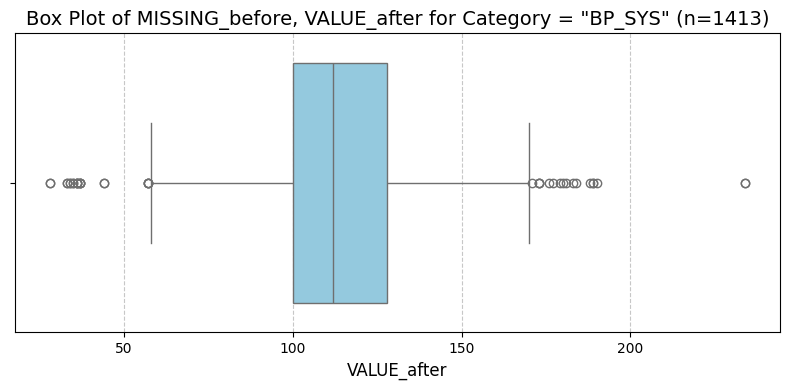

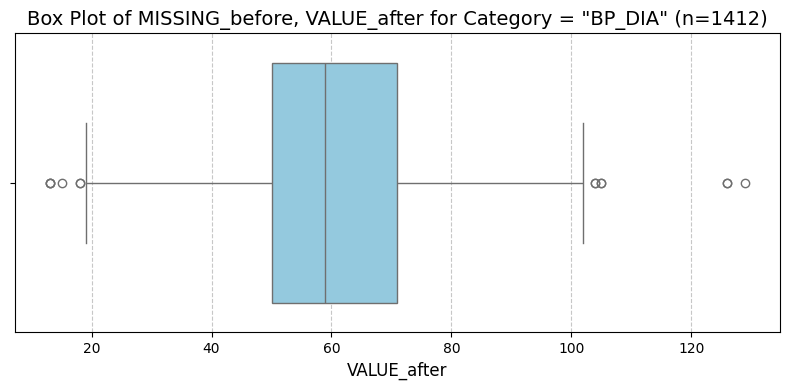

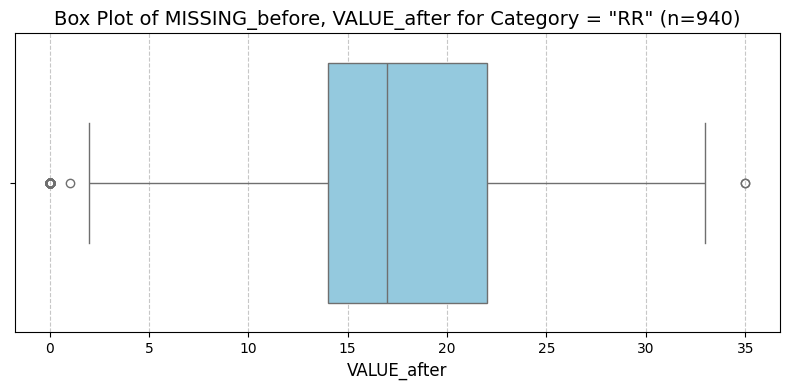

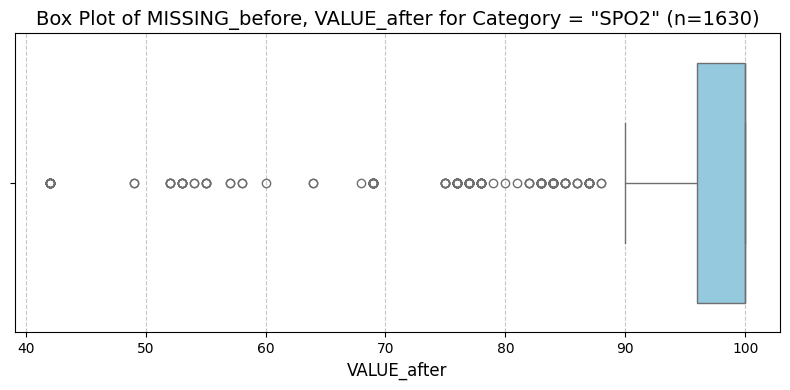

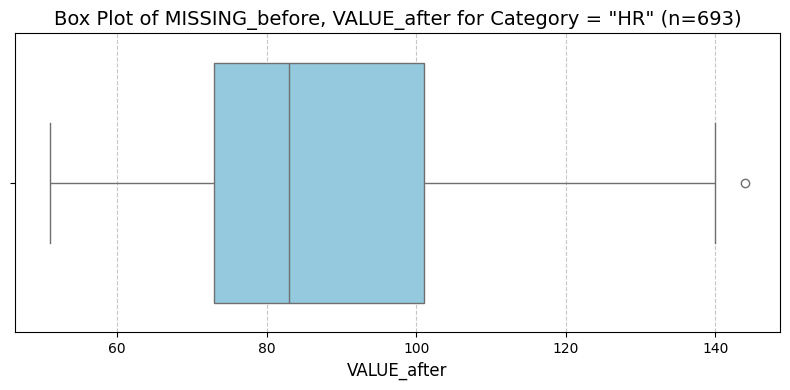

In [63]:
# Is there a trend in vital signs in the missing before transfusion events? 

# Ensure VALUE_after is numeric
na_merge['VALUE_after'] = pd.to_numeric(na_merge['VALUE_after'], errors='coerce')

# Get the unique categories
categories = na_merge['Category'].dropna().unique()

# Iterate over each category and create a plot
for category in categories:
    # Filter the data for the current category
    category_data = na_merge[na_merge['Category'] == category]
    
    # Get the count of rows for the current category
    category_count = category_data.shape[0]
    
    # Set up the figure
    plt.figure(figsize=(8, 4))  # Shorter and more compact plot
    
    # Create a horizontal box plot
    sns.boxplot(
        data=category_data,
        x='VALUE_after',
        orient='h',  # Horizontal orientation
        color='skyblue'  # Optional color
    )
    
    # Customize the plot
    plt.title(f'Box Plot of MISSING_before, VALUE_after for Category = "{category}" (n={category_count})', fontsize=14)
    plt.xlabel('VALUE_after', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Show the plot
    plt.show()



In [64]:
# The missing distribution looks like normal vital ranges so we simply remove the tranfusion events with missing before_vitals
merged_results = merged_results.dropna(subset=['VALUE_before', 'VALUE_after'])
merged_results

,SUBJECT_ID,CHARTTIME_after,endtime,linkorderid,ITEMID_after,LABEL_after,VALUE_after,VALUENUM_after,VALUEUOM_after,Category,CHARTTIME_before,starttime,ITEMID_before,LABEL_before,VALUE_before,VALUENUM_before,VALUEUOM_before,time_diff
1,96791,2144-06-11 22:36:00,2144-06-11 12:06:00,5485874,220179,Non Invasive Blood Pressure systolic,37,37.0,mmHg,BP_SYS,2144-06-11 11:28:00,2144-06-11 11:09:00,220050,Arterial Blood Pressure systolic,97,97.0,mmHg,0 days 00:19:00
2,96791,2144-06-11 22:36:00,2144-06-11 10:36:00,1615627,220179,Non Invasive Blood Pressure systolic,37,37.0,mmHg,BP_SYS,2144-06-11 09:45:00,2144-06-11 10:06:00,220050,Arterial Blood Pressure systolic,111,111.0,mmHg,0 days 00:21:00
3,96791,2144-06-11 08:02:00,2144-06-10 23:07:00,775176,220179,Non Invasive Blood Pressure systolic,39,39.0,mmHg,BP_SYS,2144-06-10 22:35:00,2144-06-10 22:35:00,220050,Arterial Blood Pressure systolic,108,108.0,mmHg,0 days 00:00:00
4,56593,2114-07-23 11:26:00,2114-07-23 04:06:00,8249652,220179,Non Invasive Blood Pressure systolic,43,43.0,mmHg,BP_SYS,2114-07-23 03:00:00,2114-07-23 03:06:00,220050,Arterial Blood Pressure systolic,138,138.0,mmHg,0 days 00:06:00
5,96791,2144-06-11 08:05:00,2144-06-11 04:28:00,8039252,220179,Non Invasive Blood Pressure systolic,44,44.0,mmHg,BP_SYS,2144-06-11 03:00:00,2144-06-11 03:28:00,220050,Arterial Blood Pressure systolic,99,99.0,mmHg,0 days 00:28:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2741216,29753,2188-08-28 05:00:00,2188-08-27 23:28:00,7526220,211,Heart Rate,80,80.0,BPM,HR,2188-08-27 22:00:00,2188-08-27 22:05:00,211,Heart Rate,80,80.0,BPM,0 days 00:05:00
2741217,29753,2188-08-28 01:00:00,2188-08-27 23:28:00,7526220,211,Heart Rate,80,80.0,BPM,HR,2188-08-27 22:00:00,2188-08-27 22:05:00,211,Heart Rate,80,80.0,BPM,0 days 00:05:00
2741218,32725,2193-09-16 18:30:00,2193-09-16 09:00:00,1659028,211,Heart Rate,92,92.0,BPM,HR,2193-09-16 08:00:00,2193-09-16 08:00:00,220045,Heart Rate,98,98.0,bpm,0 days 00:00:00
2741219,32725,2193-09-16 15:00:00,2193-09-16 09:00:00,1659028,211,Heart Rate,93,93.0,BPM,HR,2193-09-16 08:00:00,2193-09-16 08:00:00,220045,Heart Rate,98,98.0,bpm,0 days 00:00:00


In [65]:
# Look at count of each columns to find missing values 
merged_results.describe()

,SUBJECT_ID,CHARTTIME_after,endtime,linkorderid,ITEMID_after,VALUENUM_after,CHARTTIME_before,starttime,ITEMID_before,VALUENUM_before,time_diff
count,2735127.0,2735127,2735127,2735127.0,2735127.0,2.735127e+06,2735127,2735127,2735127.0,2.735127e+06,2735127
mean,61897.884915,2153-09-29 19:24:33.698470,2153-09-29 13:38:24.047034,4948001.489525,220280.43197,7.392489e+01,2153-09-29 12:24:52.708046,2153-09-29 12:26:52.450856,220254.002431,7.399174e+01,0 days 00:10:22.430534
min,34.0,2100-06-08 05:00:00,2100-06-08 04:41:00,63.0,211.0,-1.600000e+01,2100-06-08 02:30:00,2100-06-08 02:36:00,211.0,-1.300000e+01,0 days 00:00:00
25%,47158.0,2130-03-30 10:00:00,2130-03-30 03:45:00,2495111.0,220050.0,4.200000e+01,2130-03-30 02:45:00,2130-03-30 02:45:00,220050.0,4.200000e+01,0 days 00:00:00
50%,62646.0,2153-08-16 06:00:00,2153-08-15 22:05:00,4943911.0,220180.0,8.300000e+01,2153-08-15 20:20:00,2153-08-15 20:20:00,220180.0,8.400000e+01,0 days 00:05:00
75%,80970.0,2177-10-06 19:34:00,2177-10-06 11:42:00,7409188.0,220210.0,1.000000e+02,2177-10-06 10:27:00,2177-10-06 10:27:00,220210.0,1.000000e+02,0 days 00:15:00
max,99995.0,2208-05-01 17:00:00,2208-05-01 05:30:00,9999950.0,227243.0,1.141000e+05,2208-05-01 03:44:00,2208-05-01 03:30:00,227243.0,5.825000e+03,0 days 12:00:00
std,23280.3202,NaN,NaN,2870577.411512,2893.758483,8.815246e+01,NaN,NaN,2071.260181,3.999433e+01,0 days 00:20:46.865781


/tmp/ipykernel_1789/2757229392.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_results['VALUE_after'] = pd.to_numeric(merged_results['VALUE_after'], errors='coerce')


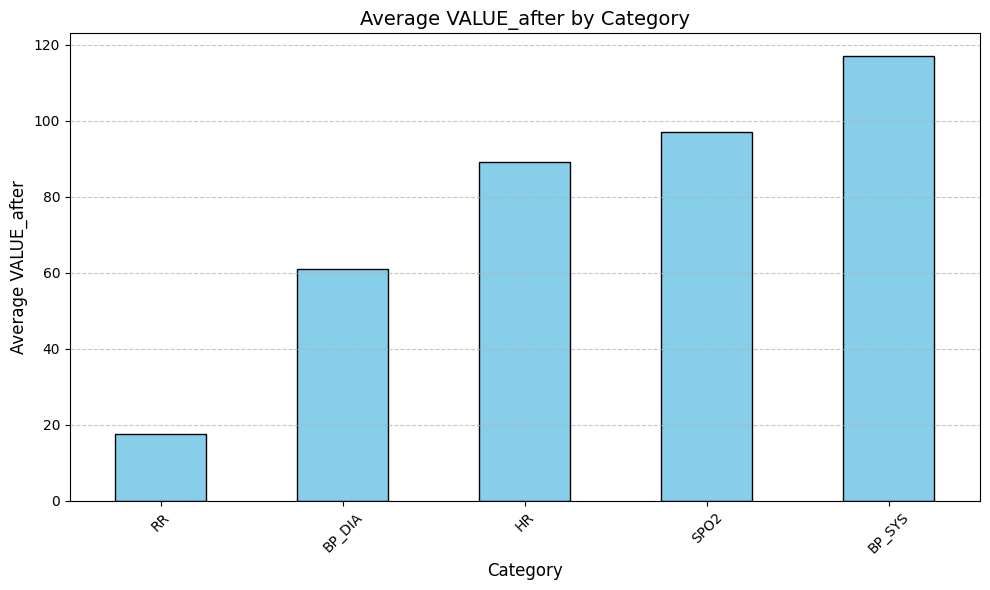

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure VALUE_after is numeric
merged_results['VALUE_after'] = pd.to_numeric(merged_results['VALUE_after'], errors='coerce')

# Group by Category and calculate the mean (or any other aggregate like sum, median, etc.)
category_means = merged_results.groupby('Category')['VALUE_after'].mean()

# Sort values for better visualization (optional)
category_means = category_means.sort_values()

# Plot a bar chart
plt.figure(figsize=(10, 6))
category_means.plot(kind='bar', color='skyblue', edgecolor='black')

# Customize the plot
plt.title('Average VALUE_after by Category', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Average VALUE_after', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


/tmp/ipykernel_1789/256016620.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_results['VALUE_after'] = pd.to_numeric(merged_results['VALUE_after'], errors='coerce')


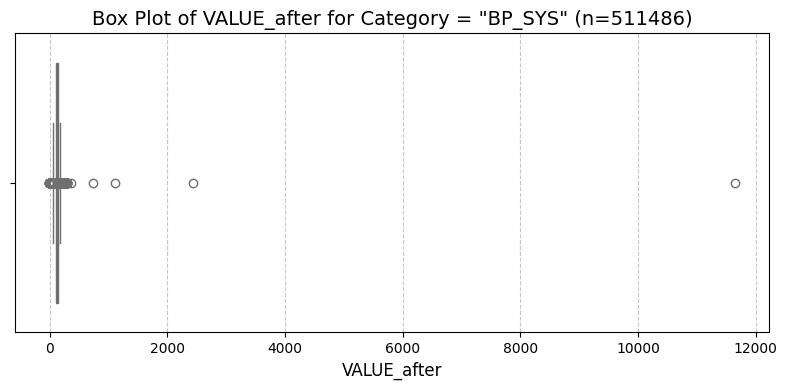

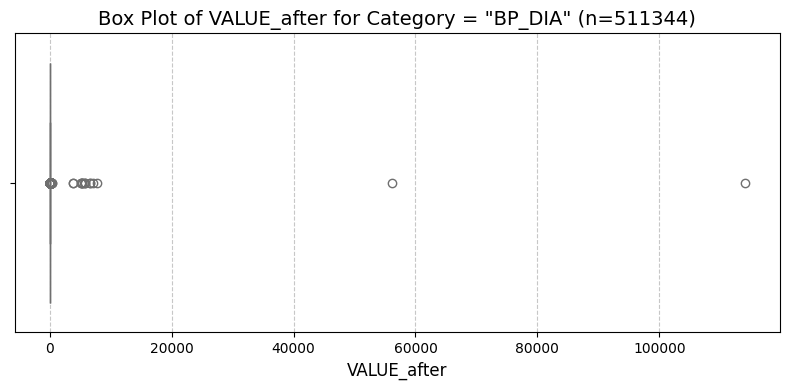

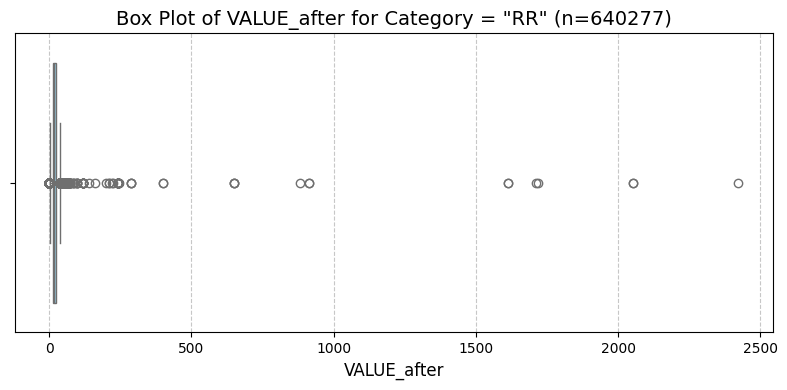

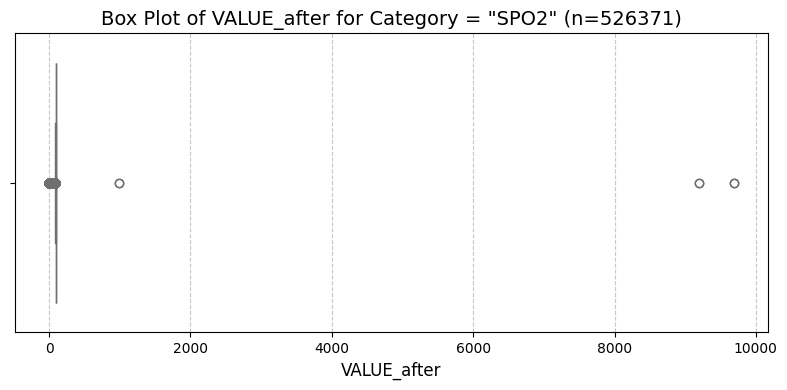

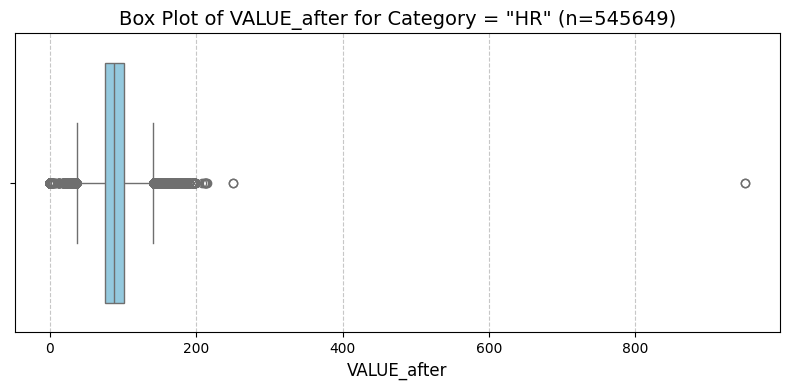

In [67]:
# Plot each vital Category after transfusion 

# Ensure VALUE_after is numeric
merged_results['VALUE_after'] = pd.to_numeric(merged_results['VALUE_after'], errors='coerce')

# Get the unique categories
categories = merged_results['Category'].dropna().unique()

# Iterate over each category and create a plot
for category in categories:
    # Filter the data for the current category
    category_data = merged_results[merged_results['Category'] == category]
    
    # Get the count of rows for the current category
    category_count = category_data.shape[0]
    
    # Set up the figure
    plt.figure(figsize=(8, 4))  # Shorter and more compact plot
    
    # Create a horizontal box plot
    sns.boxplot(
        data=category_data,
        x='VALUE_after',
        orient='h',  # Horizontal orientation
        color='skyblue'  # Optional color
    )
    
    # Customize the plot
    plt.title(f'Box Plot of VALUE_after for Category = "{category}" (n={category_count})', fontsize=14)
    plt.xlabel('VALUE_after', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Show the plot
    plt.show()



/tmp/ipykernel_1789/3204300572.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_results['VALUE_before'] = pd.to_numeric(merged_results['VALUE_before'], errors='coerce')


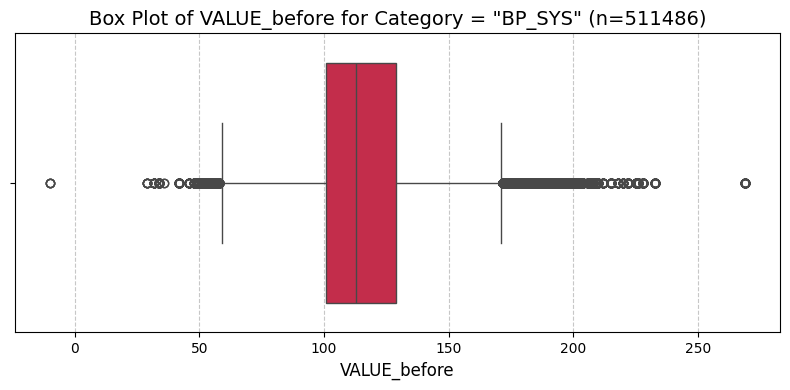

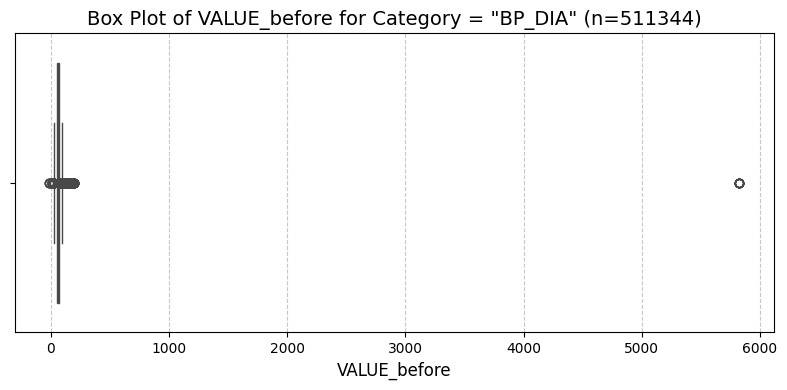

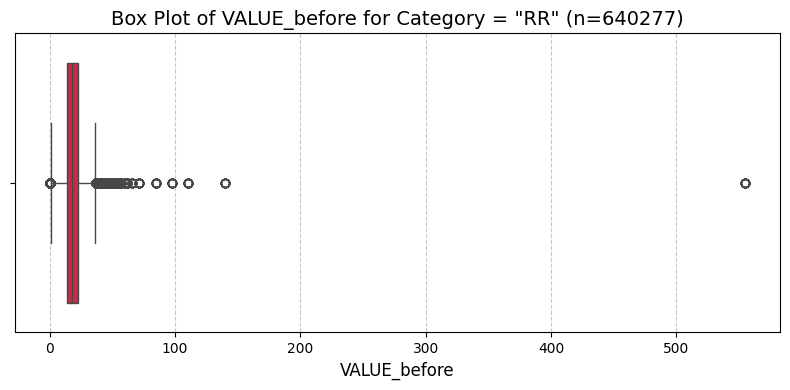

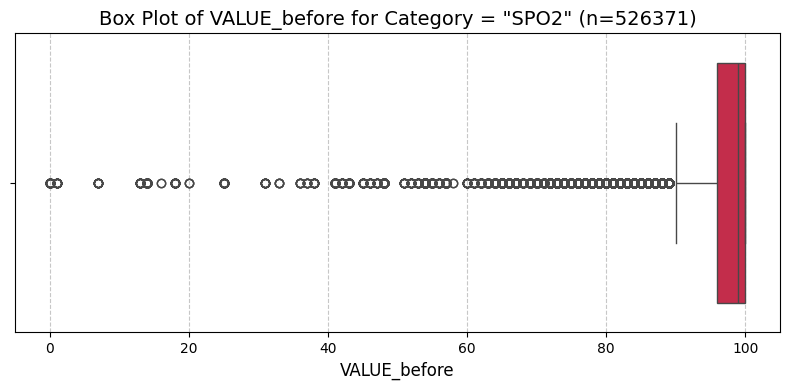

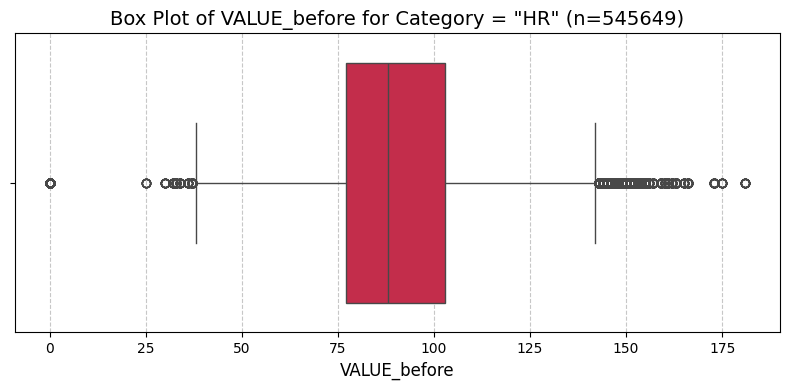

In [68]:
# Plot each vital Category before transfusion 

# Ensure VALUE_before is numeric
merged_results['VALUE_before'] = pd.to_numeric(merged_results['VALUE_before'], errors='coerce')

# Get the unique categories
categories = merged_results['Category'].dropna().unique()

# Iterate over each category and create a plot
for category in categories:
    # Filter the data for the current category
    category_data = merged_results[merged_results['Category'] == category]
    
    # Get the count of rows for the current category
    category_count = category_data.shape[0]
    
    # Set up the figure
    plt.figure(figsize=(8, 4))  # Shorter and more compact plot
    
    # Create a horizontal box plot
    sns.boxplot(
        data=category_data,
        x='VALUE_before',
        orient='h',  # Horizontal orientation
        color='crimson'  # Optional color
    )
    
    # Customize the plot
    plt.title(f'Box Plot of VALUE_before for Category = "{category}" (n={category_count})', fontsize=14)
    plt.xlabel('VALUE_before', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Show the plot
    plt.show()



In [69]:
# Want to remove VALUE_after and VALUE_before when 
## BP_SYS >= 300
## BP_DIA >= 200
## HR >= 300

# Remove rows based on the specified conditions
filtered_results = merged_results[
    ~(
        ((merged_results['Category'] == 'BP_SYS') & (merged_results['VALUE_after'] >= 300)) |
        ((merged_results['Category'] == 'BP_SYS') & (merged_results['VALUE_after'] < 40)) |
        ((merged_results['Category'] == 'BP_DIA') & (merged_results['VALUE_after'] >= 200)) |
        ((merged_results['Category'] == 'BP_DIA') & (merged_results['VALUE_after'] < 20)) |
        ((merged_results['Category'] == 'HR') & (merged_results['VALUE_after'] >= 300)) |
        ((merged_results['Category'] == 'HR') & (merged_results['VALUE_after'] < 15)) | 
        ((merged_results['Category'] == 'RR') & (merged_results['VALUE_after'] >= 100)) |
        ((merged_results['Category'] == 'RR') & (merged_results['VALUE_after'] < 3)) | 
        ((merged_results['Category'] == 'SPO2') & (merged_results['VALUE_after'] >= 100)) | 
        ((merged_results['Category'] == 'SPO2') & (merged_results['VALUE_after'] < 40)) |
        ((merged_results['Category'] == 'BP_SYS') & (merged_results['VALUE_before'] >= 300)) |
        ((merged_results['Category'] == 'BP_SYS') & (merged_results['VALUE_before'] < 40)) |
        ((merged_results['Category'] == 'BP_DIA') & (merged_results['VALUE_before'] >= 200)) |
        ((merged_results['Category'] == 'BP_DIA') & (merged_results['VALUE_before'] < 20)) |
        ((merged_results['Category'] == 'HR') & (merged_results['VALUE_before'] >= 300)) |
        ((merged_results['Category'] == 'HR') & (merged_results['VALUE_before'] < 15)) | 
        ((merged_results['Category'] == 'RR') & (merged_results['VALUE_before'] >= 100)) |
        ((merged_results['Category'] == 'RR') & (merged_results['VALUE_before'] < 3)) |
        ((merged_results['Category'] == 'SPO2') & (merged_results['VALUE_before'] >= 100)) | 
        ((merged_results['Category'] == 'SPO2') & (merged_results['VALUE_before'] < 40))
    )
]

# Display the filtered DataFrame
filtered_results


,SUBJECT_ID,CHARTTIME_after,endtime,linkorderid,ITEMID_after,LABEL_after,VALUE_after,VALUENUM_after,VALUEUOM_after,Category,CHARTTIME_before,starttime,ITEMID_before,LABEL_before,VALUE_before,VALUENUM_before,VALUEUOM_before,time_diff
4,56593,2114-07-23 11:26:00,2114-07-23 04:06:00,8249652,220179,Non Invasive Blood Pressure systolic,43.0,43.0,mmHg,BP_SYS,2114-07-23 03:00:00,2114-07-23 03:06:00,220050,Arterial Blood Pressure systolic,138,138.0,mmHg,0 days 00:06:00
5,96791,2144-06-11 08:05:00,2144-06-11 04:28:00,8039252,220179,Non Invasive Blood Pressure systolic,44.0,44.0,mmHg,BP_SYS,2144-06-11 03:00:00,2144-06-11 03:28:00,220050,Arterial Blood Pressure systolic,99,99.0,mmHg,0 days 00:28:00
6,96791,2144-06-11 20:00:00,2144-06-11 13:32:00,6560358,220179,Non Invasive Blood Pressure systolic,48.0,48.0,mmHg,BP_SYS,2144-06-11 13:00:00,2144-06-11 13:13:00,220179,Non Invasive Blood Pressure systolic,101,101.0,mmHg,0 days 00:13:00
7,87053,2150-07-31 15:10:00,2150-07-31 11:30:00,7528370,220179,Non Invasive Blood Pressure systolic,49.0,49.0,mmHg,BP_SYS,2150-07-31 11:00:00,2150-07-31 11:00:00,220050,Arterial Blood Pressure systolic,81,81.0,mmHg,0 days 00:00:00
8,10425,2199-08-17 07:15:00,2199-08-16 20:08:00,6464708,220179,Non Invasive Blood Pressure systolic,50.0,50.0,mmHg,BP_SYS,2199-08-16 19:51:00,2199-08-16 19:50:00,220179,Non Invasive Blood Pressure systolic,183,183.0,mmHg,0 days 00:01:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2741216,29753,2188-08-28 05:00:00,2188-08-27 23:28:00,7526220,211,Heart Rate,80.0,80.0,BPM,HR,2188-08-27 22:00:00,2188-08-27 22:05:00,211,Heart Rate,80,80.0,BPM,0 days 00:05:00
2741217,29753,2188-08-28 01:00:00,2188-08-27 23:28:00,7526220,211,Heart Rate,80.0,80.0,BPM,HR,2188-08-27 22:00:00,2188-08-27 22:05:00,211,Heart Rate,80,80.0,BPM,0 days 00:05:00
2741218,32725,2193-09-16 18:30:00,2193-09-16 09:00:00,1659028,211,Heart Rate,92.0,92.0,BPM,HR,2193-09-16 08:00:00,2193-09-16 08:00:00,220045,Heart Rate,98,98.0,bpm,0 days 00:00:00
2741219,32725,2193-09-16 15:00:00,2193-09-16 09:00:00,1659028,211,Heart Rate,93.0,93.0,BPM,HR,2193-09-16 08:00:00,2193-09-16 08:00:00,220045,Heart Rate,98,98.0,bpm,0 days 00:00:00


In [70]:
# Count the occurrences of each category
print("Vital counts")
print(filtered_results['Category'].value_counts())

# Group by 'SUBJECT_ID' and 'Category', then count the number of entries
group_sub = filtered_results.groupby(['SUBJECT_ID', 'Category']).size().reset_index(name='Count')
print("\n patient with vital counts")
print(group_sub['Category'].value_counts())

# Count the number of unique categories per SUBJECT_ID
unique_category_count = group_sub.groupby('SUBJECT_ID')['Category'].nunique()

# Filter to find SUBJECT_IDs with exactly 5 unique categories
subjects_with_five_categories = unique_category_count[unique_category_count == 5]

# Print the SUBJECT_IDs with exactly 5 unique categories
print(f"Unique patients with all vitals and received transfusion = {len(subjects_with_five_categories)}")

# Find unique transfusion events
group_sub2 = filtered_results.groupby(['SUBJECT_ID', 'linkorderid', 'Category']).size().reset_index(name='Count')
print("\n transfusion events with vital counts")
print(group_sub2['Category'].value_counts())

unique_category_count2 = group_sub2.groupby(['SUBJECT_ID', 'linkorderid'])['Category'].nunique()
subjects_with_five_categories2 = unique_category_count2[unique_category_count2 == 5]
print(f"Unique Transfusion events with all vitals = {len(subjects_with_five_categories2)}")


# Total number of unique patients and transfusion events
total_patients = len(filtered_results['SUBJECT_ID'].unique())
total_transfusion = len(filtered_results[['SUBJECT_ID', 'linkorderid']].drop_duplicates())
print(f"\n Total patient having at least one required vitals before and after tranfusion= {total_patients}")
print(f"Total Tranfusion events with least one required vitals before and after tranfusion= {total_transfusion}")

Vital counts
Category
HR        544528
RR        536635
BP_DIA    510133
BP_SYS    509760
SPO2      278237
Name: count, dtype: int64

 patient with vital counts
Category
HR        5822
RR        5776
BP_SYS    5768
BP_DIA    5765
SPO2      4853
Name: count, dtype: int64
Unique patients with all vitals and received transfusion = 4784

 transfusion events with vital counts
Category
HR        32499
BP_SYS    31783
BP_DIA    31768
RR        30995
SPO2      20437
Name: count, dtype: int64
Unique Transfusion events with all vitals = 19151

 Total patient having at least one required vitals before and after tranfusion= 5822
Total Tranfusion events with least one required vitals before and after tranfusion= 32520


Note Missing vital values issue!

/tmp/ipykernel_1789/3581308070.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_results['VALUE_after'] = pd.to_numeric(filtered_results['VALUE_after'], errors='coerce')


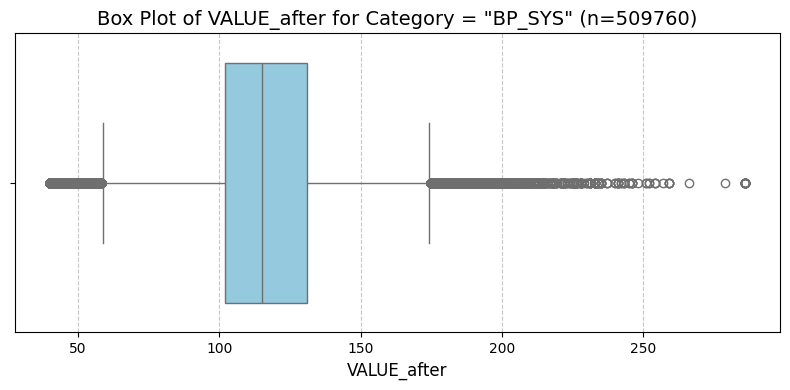

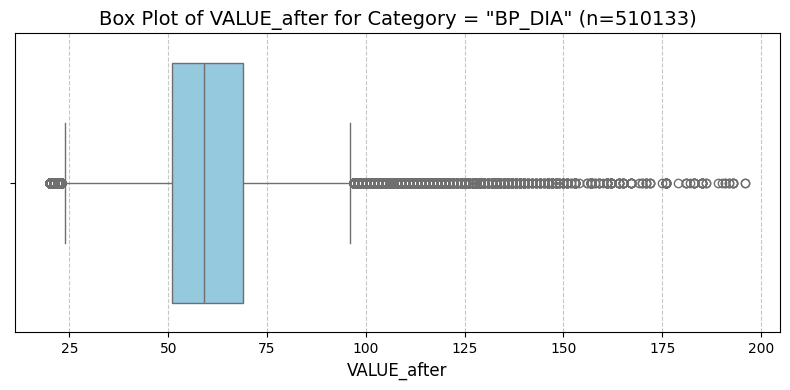

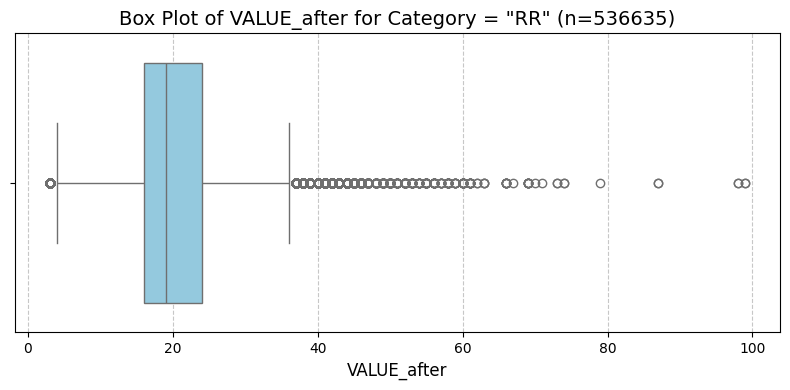

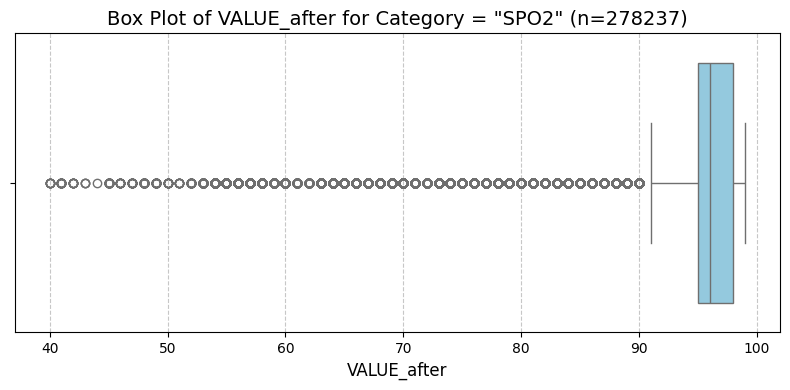

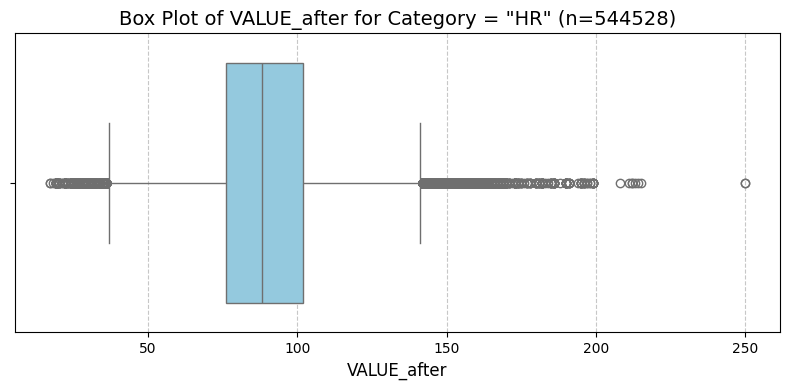

In [71]:
# Plot each vital Category after transfusion 

# Ensure VALUE_after is numeric
filtered_results['VALUE_after'] = pd.to_numeric(filtered_results['VALUE_after'], errors='coerce')

# Get the unique categories
categories = filtered_results['Category'].dropna().unique()

# Iterate over each category and create a plot
for category in categories:
    # Filter the data for the current category
    category_data = filtered_results[filtered_results['Category'] == category]
    
    # Get the count of rows for the current category
    category_count = category_data.shape[0]
    
    # Set up the figure
    plt.figure(figsize=(8, 4))  # Shorter and more compact plot
    
    # Create a horizontal box plot
    sns.boxplot(
        data=category_data,
        x='VALUE_after',
        orient='h',  # Horizontal orientation
        color='skyblue'  # Optional color
    )
    
    # Customize the plot
    plt.title(f'Box Plot of VALUE_after for Category = "{category}" (n={category_count})', fontsize=14)
    plt.xlabel('VALUE_after', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Show the plot
    plt.show()



/tmp/ipykernel_1789/3524706404.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_results['VALUE_before'] = pd.to_numeric(filtered_results['VALUE_before'], errors='coerce')


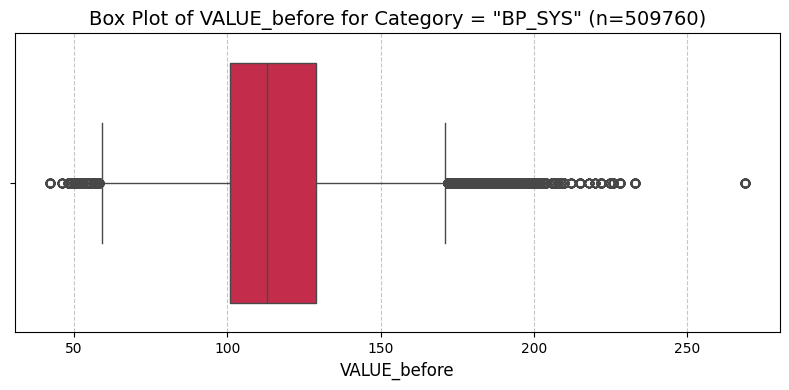

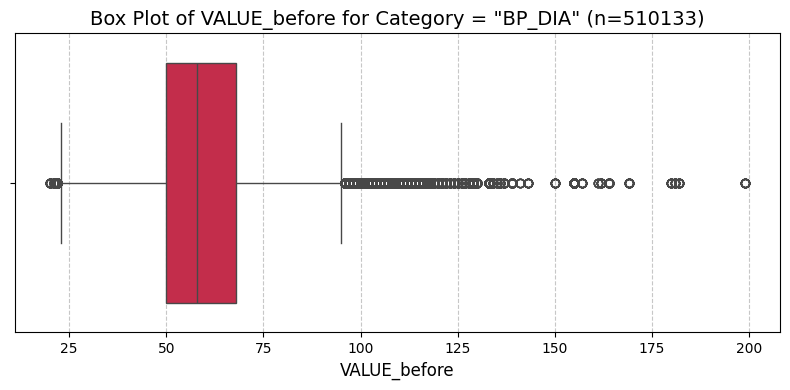

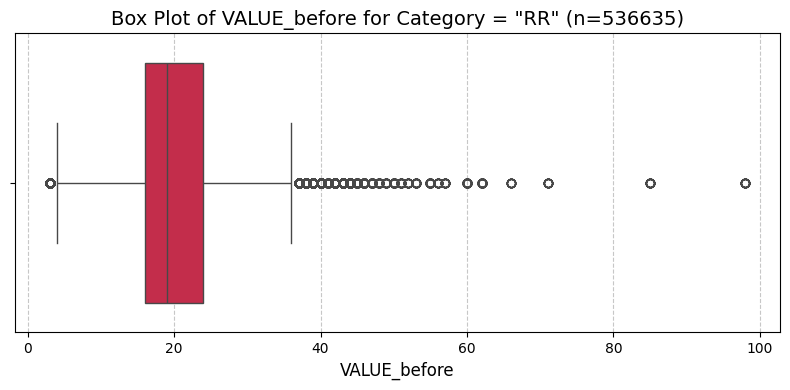

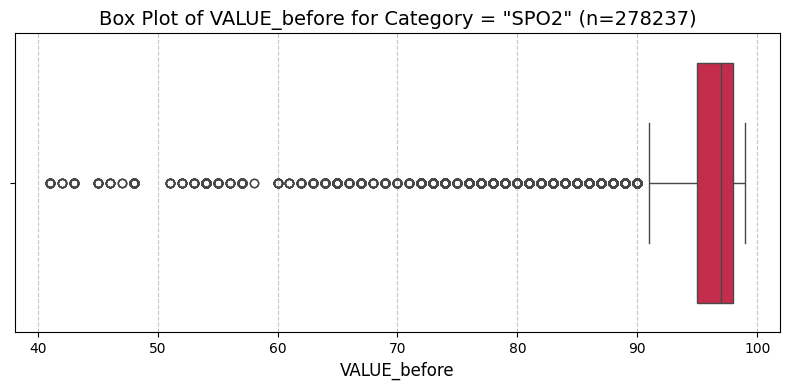

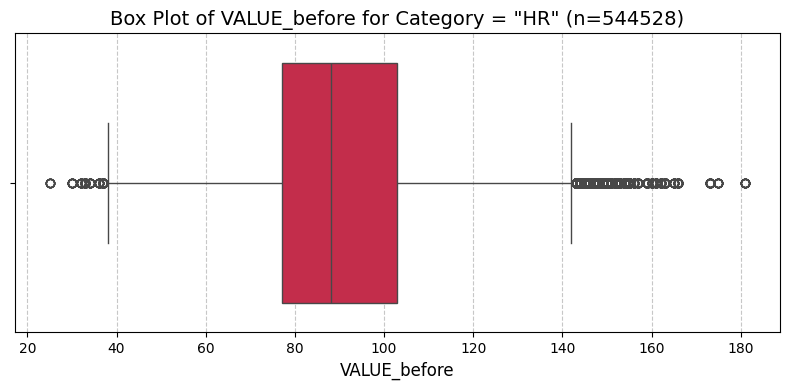

In [72]:
# Plot each vital Category before transfusion 

# Ensure VALUE_before is numeric
filtered_results['VALUE_before'] = pd.to_numeric(filtered_results['VALUE_before'], errors='coerce')

# Get the unique categories
categories = filtered_results['Category'].dropna().unique()

# Iterate over each category and create a plot
for category in categories:
    # Filter the data for the current category
    category_data = filtered_results[filtered_results['Category'] == category]
    
    # Get the count of rows for the current category
    category_count = category_data.shape[0]
    
    # Set up the figure
    plt.figure(figsize=(8, 4))  # Shorter and more compact plot
    
    # Create a horizontal box plot
    sns.boxplot(
        data=category_data,
        x='VALUE_before',
        orient='h',  # Horizontal orientation
        color='crimson'  # Optional color
    )
    
    # Customize the plot
    plt.title(f'Box Plot of VALUE_before for Category = "{category}" (n={category_count})', fontsize=14)
    plt.xlabel('VALUE_before', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Show the plot
    plt.show()



### Calculate the value differences 

In [85]:
# drop VALUE_bofore = NaN
add_filtered_results = filtered_results[filtered_results['VALUEUOM_before'].notna()]

# Change bpm to Capital BPM
add_filtered_results['VALUEUOM_before'] = add_filtered_results['VALUEUOM_before'].str.replace('bpm', 'BPM', case=False)
add_filtered_results['VALUEUOM_after'] = add_filtered_results['VALUEUOM_after'].str.replace('bpm', 'BPM', case=False)
add_filtered_results['VALUEUOM_before'] = add_filtered_results['VALUEUOM_before'].str.replace('insp/min', 'BPM', case=False)
add_filtered_results['VALUEUOM_after'] = add_filtered_results['VALUEUOM_after'].str.replace('insp/min', 'BPM', case=False)

# Check same units 
add_filtered_results[add_filtered_results['VALUEUOM_after'] != add_filtered_results['VALUEUOM_before']] # should return empty columns


,SUBJECT_ID,CHARTTIME_after,endtime,linkorderid,ITEMID_after,LABEL_after,VALUE_after,VALUENUM_after,VALUEUOM_after,Category,CHARTTIME_before,starttime,ITEMID_before,LABEL_before,VALUE_before,VALUENUM_before,VALUEUOM_before,time_diff


In [86]:
# Ensure both columns are numeric
add_filtered_results['VALUE_after'] = pd.to_numeric(add_filtered_results['VALUE_after'], errors='coerce')
add_filtered_results['VALUE_before'] = pd.to_numeric(add_filtered_results['VALUE_before'], errors='coerce')

# Calculate the difference and add it as a new column
add_filtered_results['vital_change'] = add_filtered_results['VALUE_after'] - add_filtered_results['VALUE_before']
add_filtered_results['vital_percentage'] = (add_filtered_results['VALUE_after'] - add_filtered_results['VALUE_before'])/(add_filtered_results['VALUE_before'])

# Display the updated DataFrame
add_filtered_results



,SUBJECT_ID,CHARTTIME_after,endtime,linkorderid,ITEMID_after,LABEL_after,VALUE_after,VALUENUM_after,VALUEUOM_after,Category,CHARTTIME_before,starttime,ITEMID_before,LABEL_before,VALUE_before,VALUENUM_before,VALUEUOM_before,time_diff,vital_change,vital_percentage
4,56593,2114-07-23 11:26:00,2114-07-23 04:06:00,8249652,220179,Non Invasive Blood Pressure systolic,43.0,43.0,mmHg,BP_SYS,2114-07-23 03:00:00,2114-07-23 03:06:00,220050,Arterial Blood Pressure systolic,138,138.0,mmHg,0 days 00:06:00,-95.0,-0.688406
5,96791,2144-06-11 08:05:00,2144-06-11 04:28:00,8039252,220179,Non Invasive Blood Pressure systolic,44.0,44.0,mmHg,BP_SYS,2144-06-11 03:00:00,2144-06-11 03:28:00,220050,Arterial Blood Pressure systolic,99,99.0,mmHg,0 days 00:28:00,-55.0,-0.555556
6,96791,2144-06-11 20:00:00,2144-06-11 13:32:00,6560358,220179,Non Invasive Blood Pressure systolic,48.0,48.0,mmHg,BP_SYS,2144-06-11 13:00:00,2144-06-11 13:13:00,220179,Non Invasive Blood Pressure systolic,101,101.0,mmHg,0 days 00:13:00,-53.0,-0.524752
7,87053,2150-07-31 15:10:00,2150-07-31 11:30:00,7528370,220179,Non Invasive Blood Pressure systolic,49.0,49.0,mmHg,BP_SYS,2150-07-31 11:00:00,2150-07-31 11:00:00,220050,Arterial Blood Pressure systolic,81,81.0,mmHg,0 days 00:00:00,-32.0,-0.395062
8,10425,2199-08-17 07:15:00,2199-08-16 20:08:00,6464708,220179,Non Invasive Blood Pressure systolic,50.0,50.0,mmHg,BP_SYS,2199-08-16 19:51:00,2199-08-16 19:50:00,220179,Non Invasive Blood Pressure systolic,183,183.0,mmHg,0 days 00:01:00,-133.0,-0.726776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2741216,29753,2188-08-28 05:00:00,2188-08-27 23:28:00,7526220,211,Heart Rate,80.0,80.0,BPM,HR,2188-08-27 22:00:00,2188-08-27 22:05:00,211,Heart Rate,80,80.0,BPM,0 days 00:05:00,0.0,0.000000
2741217,29753,2188-08-28 01:00:00,2188-08-27 23:28:00,7526220,211,Heart Rate,80.0,80.0,BPM,HR,2188-08-27 22:00:00,2188-08-27 22:05:00,211,Heart Rate,80,80.0,BPM,0 days 00:05:00,0.0,0.000000
2741218,32725,2193-09-16 18:30:00,2193-09-16 09:00:00,1659028,211,Heart Rate,92.0,92.0,BPM,HR,2193-09-16 08:00:00,2193-09-16 08:00:00,220045,Heart Rate,98,98.0,BPM,0 days 00:00:00,-6.0,-0.061224
2741219,32725,2193-09-16 15:00:00,2193-09-16 09:00:00,1659028,211,Heart Rate,93.0,93.0,BPM,HR,2193-09-16 08:00:00,2193-09-16 08:00:00,220045,Heart Rate,98,98.0,BPM,0 days 00:00:00,-5.0,-0.051020


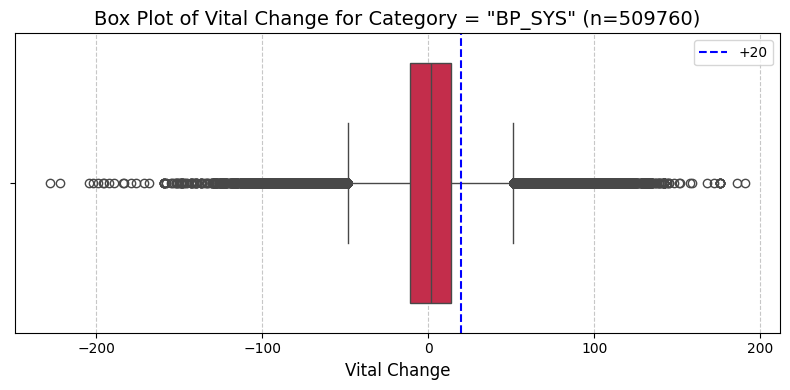

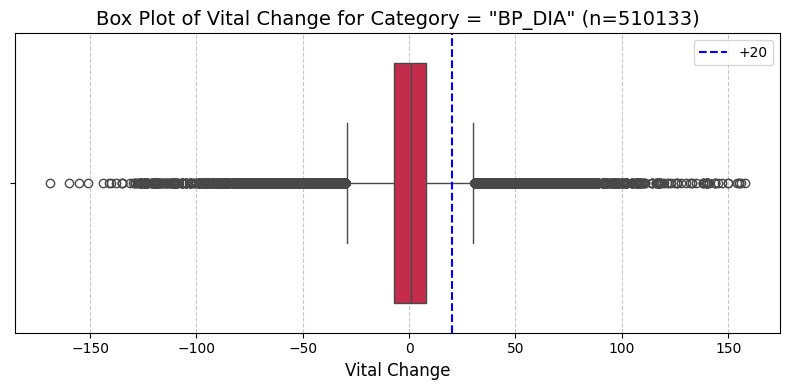

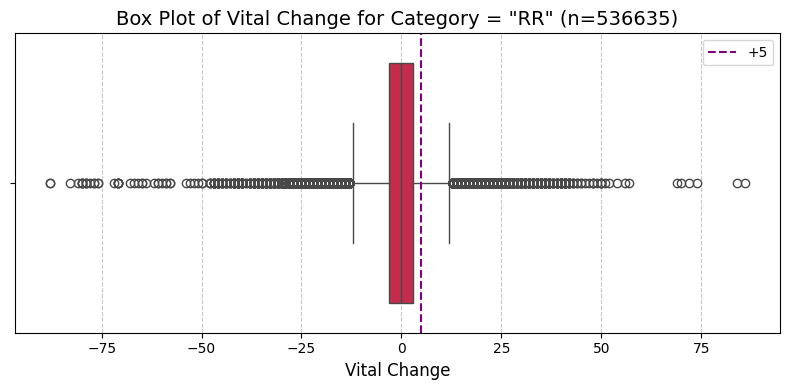

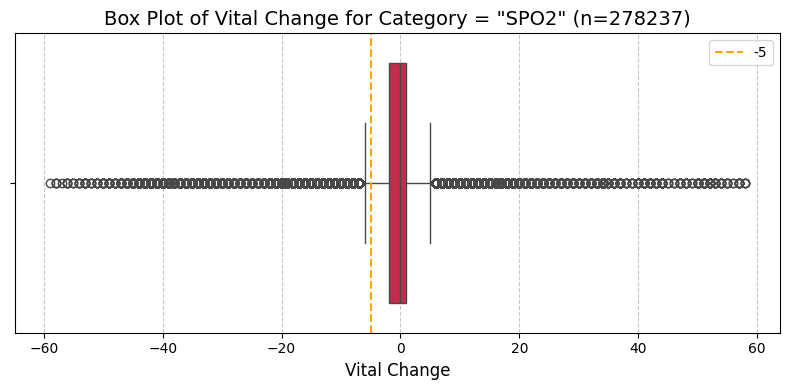

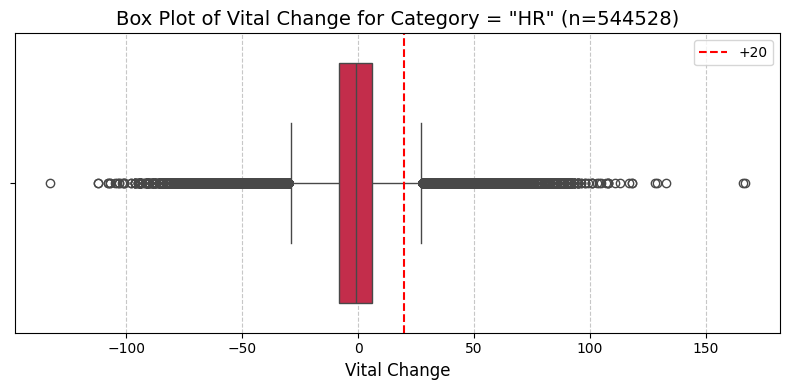

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure "vital_change" is numeric
add_filtered_results['vital_change'] = pd.to_numeric(add_filtered_results['vital_change'], errors='coerce')

# Get unique categories
categories = add_filtered_results['Category'].dropna().unique()

# Create a separate boxplot for each category
for i, category in enumerate(categories, start=1):  # Add index to track plot number
    # Filter the data for the current category
    category_data = add_filtered_results[add_filtered_results['Category'] == category]
    
    # Calculate the count of rows for the current category
    category_count = category_data.shape[0]
    
    # Set up the figure
    plt.figure(figsize=(8, 4))  # Adjust size for compactness
    
    # Create the box plot
    sns.boxplot(
        data=category_data,
        x='vital_change',
        color='Crimson',  # Optional color
        showfliers=True  # Include outliers
    )
    
    # Add vertical lines based on plot number
    if i in [1, 2]:
        plt.axvline(x=20, color='blue', linestyle='--', label='+20')
    elif i == 3:
        plt.axvline(x=5, color='purple', linestyle='--', label='+5')
    elif i == 4:
        plt.axvline(x=-5, color='orange', linestyle='--', label='-5')
    elif i == 5:
        plt.axvline(x=20, color='red', linestyle='--', label='+20')
    
    # Add a legend for the vertical lines
    plt.legend(loc='best', fontsize=10)
    
    # Customize the plot with count in the title
    plt.title(f'Box Plot of Vital Change for Category = "{category}" (n={category_count})', fontsize=14)
    plt.xlabel('Vital Change', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Show the plot
    plt.show()


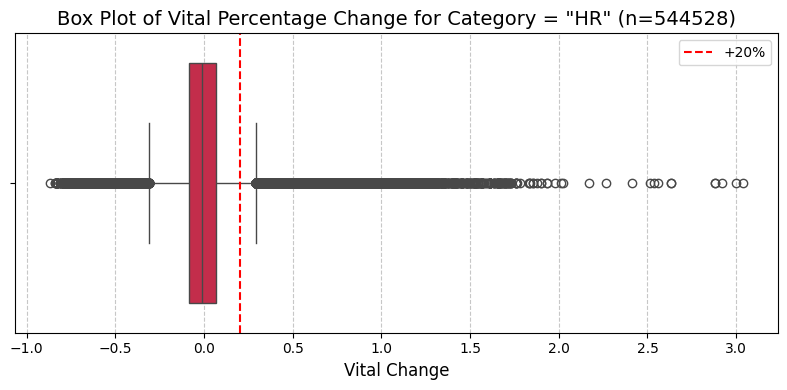

In [88]:
# Also plot HH percentage changes
# Set up the figure
plt.figure(figsize=(8, 4))  # Adjust size for compactness

category_data = add_filtered_results[add_filtered_results['Category'] == "HR"]

# Calculate the count of rows for the current category
category_count = category_data.shape[0]

# Create the box plot
sns.boxplot(
    data=category_data,
    x='vital_percentage',
    color='Crimson',  # Optional color
    showfliers=True  # Include outliers
)

# Add vertical lines based on plot number
plt.axvline(x=0.20, color='red', linestyle='--', label='+20%')

# Add a legend for the vertical lines
plt.legend(loc='best', fontsize=10)

# Customize the plot with count in the title
plt.title(f'Box Plot of Vital Percentage Change for Category = "{category}" (n={category_count})', fontsize=14)
plt.xlabel('Vital Change', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

### TACO identification results

In [89]:
# These are the denominators 
# BP_DIA OR BP_SYS
add_filtered_results.loc[add_filtered_results['Category'].isin(['BP_SYS', 'BP_DIA']), 'Category'] = "BP"

# Find unique transfusion events
group_sub2 = add_filtered_results.groupby(['SUBJECT_ID', 'linkorderid', 'Category']).size().reset_index(name='Count')
print("Strict TACO (include BP)")
vital_count2 = group_sub2.groupby(['SUBJECT_ID', 'linkorderid'])['Category'].nunique()

tr_vital1_strict = len(vital_count2[vital_count2 >= 1])
tr_vital2_strict = len(vital_count2[vital_count2 >= 2])
tr_vital3_strict = len(vital_count2[vital_count2 >= 3])
tr_vital4_strict = len(vital_count2[vital_count2 == 4])

print(f"Unique Transfusion events with all vitals = {tr_vital4_strict} \n 3+ vitals = {tr_vital3_strict} \n 2+ vitals = {tr_vital2_strict} \n 1+ vitals = {tr_vital1_strict}")


# Find unique patients
group_sub = add_filtered_results.groupby(['SUBJECT_ID', 'Category']).size().reset_index(name='Count')
vital_count = group_sub.groupby(['SUBJECT_ID'])['Category'].nunique()

pt_vital1_strict = len(vital_count[vital_count >= 1])
pt_vital2_strict = len(vital_count[vital_count >= 2])
pt_vital3_strict = len(vital_count[vital_count >= 3])
pt_vital4_strict = len(vital_count[vital_count == 4])

print(f"\n Unique patients with all vitals = {pt_vital4_strict} \n 3+ vitals = {pt_vital3_strict} \n 2+ vitals = {pt_vital2_strict} \n 1+ vitals = {pt_vital1_strict}")

Strict TACO (include BP)
Unique Transfusion events with all vitals = 19173 
 3+ vitals = 31553 
 2+ vitals = 32488 
 1+ vitals = 32520

 Unique patients with all vitals = 4788 
 3+ vitals = 5791 
 2+ vitals = 5819 
 1+ vitals = 5822


In [90]:
# Strict TACO 

# Drop BP 
loose_add_filtered = add_filtered_results[add_filtered_results['Category'] != 'BP']

# Find unique transfusion events
group_sub4 = loose_add_filtered.groupby(['SUBJECT_ID', 'linkorderid', 'Category']).size().reset_index(name='Count')
print("Loose TACO (exclude BP)")

vital_count4 = group_sub4.groupby(['SUBJECT_ID', 'linkorderid'])['Category'].nunique()

tr_vital1_loose = len(vital_count4[vital_count4 >= 1])
tr_vital2_loose = len(vital_count4[vital_count4 >= 2])
tr_vital3_loose = len(vital_count4[vital_count4 == 3])

print(f"Unique Transfusion events with all vitals = {tr_vital3_loose} \n 2+ vitals = {tr_vital2_loose} \n 1+ vitals = {tr_vital1_loose}")


# Find unique patients
group_sub3 = loose_add_filtered.groupby(['SUBJECT_ID', 'Category']).size().reset_index(name='Count')
vital_count3 = group_sub3.groupby(['SUBJECT_ID'])['Category'].nunique()

pt_vital1_loose = len(vital_count3[vital_count3 >= 1])
pt_vital2_loose = len(vital_count3[vital_count3 >= 2])
pt_vital3_loose = len(vital_count3[vital_count3 == 3])

print(f"\n Unique patients with all vitals = {pt_vital3_loose} \n 2+ vitals = {pt_vital2_loose} \n 1+ vitals = {pt_vital1_loose}")

Loose TACO (exclude BP)
Unique Transfusion events with all vitals = 19615 
 2+ vitals = 31801 
 1+ vitals = 32515

 Unique patients with all vitals = 4829 
 2+ vitals = 5800 
 1+ vitals = 5822

 Unique patients with all vitals = 4829 
 2+ vitals = 5800 
 1+ vitals = 5822


In [91]:
# Loose TACO: Want to include cases of vitals when 
# SpO2 >-5 & <95% SpO2
# RR >+5
# HR >+20%(or 20) 

# Remove rows based on the specified conditions
loose_taco_one_cri = add_filtered_results[
    (
        # ((add_filtered_results['Category'] == 'BP') & (add_filtered_results['vital_change'] > 20)) |
        # ((add_filtered_results['Category'] == 'BP') & (add_filtered_results['vital_change'] > 20)) |
        ((add_filtered_results['Category'] == 'HR') & (add_filtered_results['vital_change'] > 20)) |
        ((add_filtered_results['Category'] == 'HR') & (add_filtered_results['vital_percentage'] > 0.20)) | 
        ((add_filtered_results['Category'] == 'RR') & (add_filtered_results['vital_change'] > 5)) |
        ((add_filtered_results['Category'] == 'SPO2') & (add_filtered_results['VALUE_after'] < 95) & (add_filtered_results['vital_change'] < -5))
    )
]


# Display the filtered DataFrame
loose_taco_one_cri


,SUBJECT_ID,CHARTTIME_after,endtime,linkorderid,ITEMID_after,LABEL_after,VALUE_after,VALUENUM_after,VALUEUOM_after,Category,CHARTTIME_before,starttime,ITEMID_before,LABEL_before,VALUE_before,VALUENUM_before,VALUEUOM_before,time_diff,vital_change,vital_percentage
10708,59970,2198-05-31 09:30:00,2198-05-31 04:31:00,8446990,220210,Respiratory Rate,10.0,10.0,BPM,RR,2198-05-31 04:00:00,2198-05-31 04:15:00,224689,Respiratory Rate (spontaneous),3,3.0,BPM,0 days 00:15:00,7.0,2.333333
10776,59970,2198-05-31 09:30:00,2198-05-31 04:06:00,1708502,220210,Respiratory Rate,10.0,10.0,BPM,RR,2198-05-31 04:00:00,2198-05-31 03:50:00,224689,Respiratory Rate (spontaneous),3,3.0,BPM,0 days 00:10:00,7.0,2.333333
11016,46092,2195-03-19 19:00:00,2195-03-19 14:10:00,4268207,220210,Respiratory Rate,12.0,12.0,BPM,RR,2195-03-19 13:00:00,2195-03-19 13:10:00,220210,Respiratory Rate,5,5.0,BPM,0 days 00:10:00,7.0,1.400000
11069,29035,2153-07-23 10:00:00,2153-07-22 22:00:00,3673607,220210,Respiratory Rate,12.0,12.0,BPM,RR,2153-07-22 21:02:00,2153-07-22 21:30:00,220210,Respiratory Rate,6,6.0,BPM,0 days 00:28:00,6.0,1.000000
11123,96093,2101-09-05 15:00:00,2101-09-05 05:45:00,2213215,220210,Respiratory Rate,12.0,12.0,BPM,RR,2101-09-05 05:01:00,2101-09-05 04:45:00,220210,Respiratory Rate,4,4.0,BPM,0 days 00:16:00,8.0,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2741210,77926,2198-03-30 17:00:00,2198-03-30 06:07:00,2536379,224689,Respiratory Rate (spontaneous),39.0,39.0,BPM,RR,2198-03-30 05:00:00,2198-03-30 05:07:00,220210,Respiratory Rate,32,32.0,BPM,0 days 00:07:00,7.0,0.218750
2741211,54639,2154-07-09 20:15:00,2154-07-09 14:55:00,4627869,224689,Respiratory Rate (spontaneous),40.0,40.0,BPM,RR,2154-07-09 12:00:00,2154-07-09 12:25:00,220210,Respiratory Rate,14,14.0,BPM,0 days 00:25:00,26.0,1.857143
2741213,40548,2156-08-02 01:39:00,2156-08-01 19:17:00,9666738,224689,Respiratory Rate (spontaneous),41.0,41.0,BPM,RR,2156-08-01 17:17:00,2156-08-01 17:17:00,220210,Respiratory Rate,30,30.0,BPM,0 days 00:00:00,11.0,0.366667
2741214,82326,2105-12-30 08:00:00,2105-12-30 02:00:00,3976962,224689,Respiratory Rate (spontaneous),41.0,41.0,BPM,RR,2105-12-30 01:00:00,2105-12-30 01:00:00,220210,Respiratory Rate,19,19.0,BPM,0 days 00:00:00,22.0,1.157895


In [92]:
# Drop duplicates to keep only one BP
loose_taco_pt_results = loose_taco_one_cri.drop_duplicates(subset=['SUBJECT_ID', 'Category'], keep='first')

# Group by 'SUBJECT_ID' and 'Category', then count the number of entries
loose_taco_pt_results = loose_taco_pt_results.groupby(['SUBJECT_ID', 'Category']).size().reset_index(name='Count')
print("Loose vital criteria (exclude BP)")
print("Counts of patients meeting each vital criteria:")
print(loose_taco_pt_results['Category'].value_counts())

# Count the number of unique categories per SUBJECT_ID
uni_pt_taco_loose = loose_taco_pt_results.groupby('SUBJECT_ID')['Category'].nunique()

# Display the number of patients who meets n criteria 
print("\n number of patients who meet n (1-3) vital criteria ")
print(uni_pt_taco_loose.value_counts())

# Print the SUBJECT_IDs with exactly 3 unique categories
print('\n')
print(f"TACO Patients who meet all vitals criteria = {len(uni_pt_taco_loose[uni_pt_taco_loose >= 3])} ({len(uni_pt_taco_loose[uni_pt_taco_loose >= 3])/pt_vital3_loose*100:.3f}%)")
print(f"TACO Patients who meet 2+ vitals criteria = {len(uni_pt_taco_loose[uni_pt_taco_loose >= 2])} ({len(uni_pt_taco_loose[uni_pt_taco_loose >= 2])/pt_vital2_loose*100:.3f}%)")
print(f"TACO Patients who meet 1+ vitals criteria = {len(uni_pt_taco_loose[uni_pt_taco_loose >= 1])} ({len(uni_pt_taco_loose[uni_pt_taco_loose >= 1])/pt_vital1_loose*100:.3f}%)")

# Count by tranfusion events 
loose_taco_tf_results = loose_taco_one_cri.drop_duplicates(subset=['SUBJECT_ID', 'linkorderid', 'Category'], keep='first')
loose_taco_tf_results = loose_taco_tf_results.groupby(['SUBJECT_ID', 'linkorderid', 'Category']).size().reset_index(name='Count')
print("\n Counts of transfusion events meeting each vital criteria:")
print(loose_taco_tf_results['Category'].value_counts())
uni_tf_taco_loose = loose_taco_tf_results.groupby(['SUBJECT_ID', 'linkorderid'])['Category'].nunique()
print('\n')
print("number of tranfusion events which meet n (1-3) vital criteria")
print(uni_tf_taco_loose.value_counts())

print('\n')
print(f"TACO transfusion events which meet all vitals criteria = {len(uni_tf_taco_loose[uni_tf_taco_loose >= 3])} ({len(uni_tf_taco_loose[uni_tf_taco_loose >= 3])/tr_vital3_loose*100:.3f}%)")
print(f"TACO transfusion events which meet 2+ vitals criteria = {len(uni_tf_taco_loose[uni_tf_taco_loose >= 2])} ({len(uni_tf_taco_loose[uni_tf_taco_loose >= 2])/tr_vital2_loose*100:.3f}%)")
print(f"TACO transfusion events which meet 1+ vitals criteria = {len(uni_tf_taco_loose[uni_tf_taco_loose >= 1])} ({len(uni_tf_taco_loose[uni_tf_taco_loose >= 1])/tr_vital1_loose*100:.3f}%)")


Loose vital criteria (exclude BP)
Counts of patients meeting each vital criteria:
Category
RR      4313
HR      2882
SPO2    1795
Name: count, dtype: int64

 number of patients who meet n (1-3) vital criteria 
Category
2    2035
1    1860
3    1020
Name: count, dtype: int64


TACO Patients who meet all vitals criteria = 1020 (21.122%)
TACO Patients who meet 2+ vitals criteria = 3055 (52.672%)
TACO Patients who meet 1+ vitals criteria = 4915 (84.421%)

 Counts of transfusion events meeting each vital criteria:
Category
RR      14787
HR       8244
SPO2     4217
Name: count, dtype: int64


number of tranfusion events which meet n (1-3) vital criteria
Category
1    13540
2     5630
3      816
Name: count, dtype: int64


TACO transfusion events which meet all vitals criteria = 816 (4.160%)
TACO transfusion events which meet 2+ vitals criteria = 6446 (20.270%)
TACO transfusion events which meet 1+ vitals criteria = 19986 (61.467%)


In [93]:
# Strict TACO: Want to include cases of vitals when  
# SpO2 >-5 & <95% SpO2
# RR >+5
# HR >+20%(or 20) 
# BP D/S either OR: >20

# Remove rows based on the specified conditions
strict_taco_one_cri = add_filtered_results[
    (
        ((add_filtered_results['Category'] == 'BP') & (add_filtered_results['vital_change'] > 20)) |
        ((add_filtered_results['Category'] == 'HR') & (add_filtered_results['vital_change'] > 20)) |
        ((add_filtered_results['Category'] == 'HR') & (add_filtered_results['vital_percentage'] > 0.20)) | 
        ((add_filtered_results['Category'] == 'RR') & (add_filtered_results['vital_change'] > 5)) |
        ((add_filtered_results['Category'] == 'SPO2') & (add_filtered_results['VALUE_after'] < 95) & (add_filtered_results['vital_change'] < -5))
    )
]


# Display the filtered DataFrame
strict_taco_one_cri

,SUBJECT_ID,CHARTTIME_after,endtime,linkorderid,ITEMID_after,LABEL_after,VALUE_after,VALUENUM_after,VALUEUOM_after,Category,CHARTTIME_before,starttime,ITEMID_before,LABEL_before,VALUE_before,VALUENUM_before,VALUEUOM_before,time_diff,vital_change,vital_percentage
443,17002,2153-04-16 23:10:00,2153-04-16 22:00:00,8146065,220179,Non Invasive Blood Pressure systolic,91.0,91.0,mmHg,BP,2153-04-16 21:34:00,2153-04-16 21:30:00,220179,Non Invasive Blood Pressure systolic,69,69.0,mmHg,0 days 00:04:00,22.0,0.318841
510,60798,2188-04-13 00:03:00,2188-04-12 15:56:00,4845950,220179,Non Invasive Blood Pressure systolic,93.0,93.0,mmHg,BP,2188-04-12 14:00:00,2188-04-12 14:04:00,220179,Non Invasive Blood Pressure systolic,72,72.0,mmHg,0 days 00:04:00,21.0,0.291667
556,66745,2145-11-27 17:13:00,2145-11-27 15:57:00,4181287,220179,Non Invasive Blood Pressure systolic,94.0,94.0,mmHg,BP,2145-11-27 13:00:00,2145-11-27 13:09:00,220050,Arterial Blood Pressure systolic,72,72.0,mmHg,0 days 00:09:00,22.0,0.305556
676,99611,2100-12-23 11:00:00,2100-12-22 23:31:00,4585403,220179,Non Invasive Blood Pressure systolic,96.0,96.0,mmHg,BP,2100-12-22 22:45:00,2100-12-22 22:31:00,220050,Arterial Blood Pressure systolic,74,74.0,mmHg,0 days 00:14:00,22.0,0.297297
711,89119,2167-07-31 15:30:00,2167-07-31 04:15:00,9334818,220179,Non Invasive Blood Pressure systolic,96.0,96.0,mmHg,BP,2167-07-31 03:00:00,2167-07-31 03:00:00,220179,Non Invasive Blood Pressure systolic,71,71.0,mmHg,0 days 00:00:00,25.0,0.352113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2741210,77926,2198-03-30 17:00:00,2198-03-30 06:07:00,2536379,224689,Respiratory Rate (spontaneous),39.0,39.0,BPM,RR,2198-03-30 05:00:00,2198-03-30 05:07:00,220210,Respiratory Rate,32,32.0,BPM,0 days 00:07:00,7.0,0.218750
2741211,54639,2154-07-09 20:15:00,2154-07-09 14:55:00,4627869,224689,Respiratory Rate (spontaneous),40.0,40.0,BPM,RR,2154-07-09 12:00:00,2154-07-09 12:25:00,220210,Respiratory Rate,14,14.0,BPM,0 days 00:25:00,26.0,1.857143
2741213,40548,2156-08-02 01:39:00,2156-08-01 19:17:00,9666738,224689,Respiratory Rate (spontaneous),41.0,41.0,BPM,RR,2156-08-01 17:17:00,2156-08-01 17:17:00,220210,Respiratory Rate,30,30.0,BPM,0 days 00:00:00,11.0,0.366667
2741214,82326,2105-12-30 08:00:00,2105-12-30 02:00:00,3976962,224689,Respiratory Rate (spontaneous),41.0,41.0,BPM,RR,2105-12-30 01:00:00,2105-12-30 01:00:00,220210,Respiratory Rate,19,19.0,BPM,0 days 00:00:00,22.0,1.157895


In [94]:
# BP_DIA OR BP_SYS
strict_taco_one_cri.loc[strict_taco_one_cri['Category'].isin(['BP_SYS', 'BP_DIA']), 'Category'] = "BP"

# Drop duplicates to keep only one BP
strict_taco_pt_results = strict_taco_one_cri.drop_duplicates(subset=['SUBJECT_ID', 'Category'], keep='first')

# Group by 'SUBJECT_ID' and 'Category', then count the number of entries
strict_taco_pt_results = strict_taco_pt_results.groupby(['SUBJECT_ID', 'Category']).size().reset_index(name='Count')

print("Strict vital criteria (include sBP or dBP +20)")
print("Counts of patients meeting each vital criteria:")
print(strict_taco_pt_results['Category'].value_counts())

# Count the number of unique categories per SUBJECT_ID
uni_pt_taco_strict = strict_taco_pt_results.groupby('SUBJECT_ID')['Category'].nunique()

# Display the number of patients who meets n criteria 
print("\n number of patients who meet n (1-4) vital criteria ")
print(uni_pt_taco_strict.value_counts())

# Print the SUBJECT_IDs with exactly 4 unique categories
print('\n')
print(f"TACO Patients who meet all vitals criteria = {len(uni_pt_taco_strict[uni_pt_taco_strict == 4])} ({len(uni_pt_taco_strict[uni_pt_taco_strict == 4])/pt_vital4_strict*100:.3f}%)")
print(f"TACO Patients who meet 3+ vitals criteria = {len(uni_pt_taco_strict[uni_pt_taco_strict >= 3])} ({len(uni_pt_taco_strict[uni_pt_taco_strict >= 3])/pt_vital3_strict*100:.3f}%)")
print(f"TACO Patients who meet 2+ vitals criteria = {len(uni_pt_taco_strict[uni_pt_taco_strict >= 2])} ({len(uni_pt_taco_strict[uni_pt_taco_strict >= 2])/pt_vital2_strict*100:.3f}%)")
print(f"TACO Patients who meet 1+ vitals criteria = {len(uni_pt_taco_strict[uni_pt_taco_strict >= 1])} ({len(uni_pt_taco_strict[uni_pt_taco_strict >= 1])/pt_vital1_strict*100:.3f}%)")

# Count by tranfusion events 
strict_taco_tf_results = strict_taco_one_cri.drop_duplicates(subset=['SUBJECT_ID', 'linkorderid', 'Category'], keep='first')
strict_taco_tf_results = strict_taco_tf_results.groupby(['SUBJECT_ID', 'linkorderid', 'Category']).size().reset_index(name='Count')

print("\n Counts of patients meeting each vital criteria:")
print(strict_taco_tf_results['Category'].value_counts())

uni_tf_taco_strict = strict_taco_tf_results.groupby(['SUBJECT_ID', 'linkorderid'])['Category'].nunique()
print('\n')
print("number of tranfusion events which meet n (1-4) vital criteria")
print(uni_tf_taco_strict.value_counts())

print('\n')
print(f"TACO transfusion events which meet all vitals criteria = {len(uni_tf_taco_strict[uni_tf_taco_strict == 4])} ({len(uni_tf_taco_strict[uni_tf_taco_strict == 4])/tr_vital4_strict*100:.3f}%)")
print(f"TACO transfusion events which meet 3+ vitals criteria = {len(uni_tf_taco_strict[uni_tf_taco_strict >= 3])} ({len(uni_tf_taco_strict[uni_tf_taco_strict >= 3])/tr_vital3_strict*100:.3f}%)")
print(f"TACO transfusion events which meet 2+ vitals criteria = {len(uni_tf_taco_strict[uni_tf_taco_strict >= 2])} ({len(uni_tf_taco_strict[uni_tf_taco_strict >= 2])/tr_vital2_strict*100:.3f}%)")
print(f"TACO transfusion events which meet 1+ vitals criteria = {len(uni_tf_taco_strict[uni_tf_taco_strict >= 1])} ({len(uni_tf_taco_strict[uni_tf_taco_strict >= 1])/tr_vital1_strict*100:.3f}%)")



Strict vital criteria (include sBP or dBP +20)
Counts of patients meeting each vital criteria:
Category
BP      4679
RR      4313
HR      2882
SPO2    1795
Name: count, dtype: int64

 number of patients who meet n (1-4) vital criteria 
Category
3    1816
2    1677
1     995
4     968
Name: count, dtype: int64


TACO Patients who meet all vitals criteria = 968 (20.217%)
TACO Patients who meet 3+ vitals criteria = 2784 (48.075%)
TACO Patients who meet 2+ vitals criteria = 4461 (76.663%)
TACO Patients who meet 1+ vitals criteria = 5456 (93.714%)

 Counts of patients meeting each vital criteria:
Category
BP      18411
RR      14787
HR       8244
SPO2     4217
Name: count, dtype: int64


number of tranfusion events which meet n (1-4) vital criteria
Category
1    11922
2     9886
3     3871
4      588
Name: count, dtype: int64


TACO transfusion events which meet all vitals criteria = 588 (3.067%)
TACO transfusion events which meet 3+ vitals criteria = 4459 (14.132%)
TACO transfusion events 

In [95]:
## Print TACO example patients

In [96]:
# Print TACO vital distributions